# Predcition of Hospital Admission Related to Otitis Media

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis media (otmedia).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'otmedia_date_'+str(i), 'otmedia_ab_date_'+str(i), 'otmedia_ab_type_'+str(i),
                   'incdt_otmedia_date_'+str(i), 'admitted_otmedia_date_'+str(i), 'sgss_gp_cov_otmedia_date_'+str(i)]]
    
    #drop rows with no otmedia reord
    datum = datum[datum['otmedia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with otmedia_i
    datum = datum[datum['sgss_gp_cov_otmedia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'otmedia_date_'+str(i): 'otmedia_date', 'otmedia_ab_date_'+str(i): 'otmedia_ab_date', 
                           'otmedia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_otmedia_date_'+str(i): 'incdt_otmedia_date', 'incdt_otmedia_type_'+str(i): 'incdt_otmedia_type',
                           'admitted_otmedia_date_'+str(i): 'admitted_otmedia_date',
                           'sgss_gp_cov_otmedia_date_'+str(i): 'sgss_gp_cov_otmedia_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_antibacterial_brit_cat_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_otmedia.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 otmedias and concatenate them 
data_otmedia_1 = proc_infec_data(data,1)
data_otmedia_2 = proc_infec_data(data,2)
data_otmedia_3 = proc_infec_data(data,3)
data_otmedia_4 = proc_infec_data(data,4)
data_otmedia_5 = proc_infec_data(data,5)
data_otmedia_6 = proc_infec_data(data,6)
data_otmedia_7 = proc_infec_data(data,7)
data_otmedia_8 = proc_infec_data(data,8)
data_otmedia_9 = proc_infec_data(data,9)
data_otmedia_10 = proc_infec_data(data,10)
data_otmedia_11 = proc_infec_data(data,11)
data_otmedia_12 = proc_infec_data(data,12)
data_otmedia_13 = proc_infec_data(data,13)
data_otmedia_14 = proc_infec_data(data,14)
data_otmedia_15 = proc_infec_data(data,15)
data_otmedia_16 = proc_infec_data(data,16)
data_otmedia_17 = proc_infec_data(data,17)
data_otmedia_18 = proc_infec_data(data,18)
data_otmedia_19 = proc_infec_data(data,19)
data_otmedia_20 = proc_infec_data(data,20)

data_otmedia = pd.concat([data_otmedia_1, data_otmedia_2, data_otmedia_3, data_otmedia_4, data_otmedia_5, data_otmedia_6, data_otmedia_7, data_otmedia_8, data_otmedia_9, data_otmedia_10, data_otmedia_11, data_otmedia_12, data_otmedia_13, data_otmedia_14, data_otmedia_15, data_otmedia_16, data_otmedia_17, data_otmedia_18, data_otmedia_19, data_otmedia_20])
data_otmedia.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_otmedia['otmedia_date'] = data_otmedia['otmedia_date'].astype('datetime64[ns]')
data_otmedia['admitted_otmedia_date'] = data_otmedia['admitted_otmedia_date'].astype('datetime64[ns]')
data_otmedia.died_date = data_otmedia.died_date.astype('datetime64[ns]')
data_otmedia.deregistered_date = data_otmedia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_otmedia['date'] = data_otmedia['otmedia_date'] 
data_otmedia['date'] = data_otmedia['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_otmedia with today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != last_1_month_date_y_m]
data_otmedia = data_otmedia[data_otmedia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of otmedia records
data_otmedia['season'] = np.nan
data_otmedia['date_month'] = pd.DatetimeIndex(data_otmedia['date']).month

conditions = [
    (data_otmedia['date_month'] >= 3) & (data_otmedia['date_month'] <= 5),
    (data_otmedia['date_month'] >= 6) & (data_otmedia['date_month'] <= 8),
    (data_otmedia['date_month'] >= 9) & (data_otmedia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_otmedia['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_otmedia.loc[(data_otmedia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_otmedia.loc[((data_otmedia['date'] >= '2020-01') & (data_otmedia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_otmedia.loc[(data_otmedia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_otmedia.loc[data_otmedia['admitted_otmedia_date'].isnull(), 'event_otmedia_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_otmedia['delta_otmedia_admitted'] = (data_otmedia['admitted_otmedia_date'] - data_otmedia['otmedia_date']).dt.days
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] >= 0) & (data_otmedia['delta_otmedia_admitted'] <= 30)), 'event_otmedia_admitted'] = 1

#scenario 2
#drop whoever was admitted before otmedia consultation, i.e. negative value for delta_otmedia_admitted
data_otmedia = data_otmedia[~(data_otmedia['delta_otmedia_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_otmedia['delta_admitted_died'] = (data_otmedia['died_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_died'] >= 0) & (data_otmedia['delta_admitted_died'] <= 30)), 'event_otmedia_admitted'] = 0

#scenario 3
#censor deregistered patients
data_otmedia['delta_admitted_deregistered'] = (data_otmedia['deregistered_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_deregistered'] > 0) & (data_otmedia['delta_admitted_deregistered'] <= 30)), 'event_otmedia_admitted'] = 0

#agg scenario 3s
data_otmedia['delta_admitted_died_deregistered'] = data_otmedia['delta_admitted_deregistered'].combine_first(data_otmedia['delta_admitted_died'])
data_otmedia.loc[data_otmedia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_otmedia['event_otmedia_admitted'] = data_otmedia['event_otmedia_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_otmedia['duration_otmedia_admitted'] = data_otmedia['delta_otmedia_admitted'].combine_first(data_otmedia['delta_admitted_died_deregistered'])
data_otmedia['duration_otmedia_admitted'] = data_otmedia['duration_otmedia_admitted'].replace(np.NaN, 30)
data_otmedia.loc[(data_otmedia['duration_otmedia_admitted'] > 30), 'duration_otmedia_admitted'] = 30

#give value 1 to event_otmedia_admitted if duration_otmedia_admitted is greater or equal to 0 and less than 30
data_otmedia.loc[((data_otmedia['duration_otmedia_admitted'] >= 0) & (data_otmedia['duration_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

#drop any rows with value 0 in duration column
data_otmedia = data_otmedia[~(data_otmedia['duration_otmedia_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] > 0) & (data_otmedia['delta_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_otmedia = data_otmedia[~(data_otmedia['age'] < 18)] 
data_otmedia['age'][data_otmedia['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '0-4']
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_otmedia['bmi'][data_otmedia['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_otmedia['bmi'] = data_otmedia['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_otmedia['antibacterial_brit'][data_otmedia['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_otmedia.columns) and (data_otmedia['region'].isnull().sum() > 0):
   data_otmedia = data_otmedia[data_otmedia['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_otmedia.columns) and (data_otmedia['antibacterial_brit'].isnull().sum() > 0):
    data_otmedia['antibacterial_brit'] = data_otmedia['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_otmedia.columns) and (data_otmedia['ethnicity'].isnull().sum() > 0):
    data_otmedia['ethnicity'] = data_otmedia['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_otmedia.columns) and (data_otmedia['smoking_status'].isnull().sum() > 0):
    data_otmedia['smoking_status'] = data_otmedia['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_otmedia.columns) and (data_otmedia['imd'].isnull().sum() > 0):
    data_otmedia['imd'] = data_otmedia['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_otmedia['bmi_cat'] = 5

for idx, x in enumerate(data_otmedia['bmi_cat']):
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 30:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 25) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 30):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 18.5) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 25):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 18.5:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_otmedia.columns) and (data_otmedia['bmi_cat'].isnull().sum() > 0):
    data_otmedia['bmi_cat'] = data_otmedia['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_otmedia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_otmedia['ab_type_cat'] = np.where(data_otmedia['ab_type'].isin(ab_series[mask].index),'other',data_otmedia['ab_type'])
#assign no to non ab users
data_otmedia.loc[data_otmedia['otmedia_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_otmedia['ab_type_cat'] = data_otmedia['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"ethnicity": dict_ethnicity})
data_otmedia = data_otmedia.replace({"smoking_status": dict_smoking})
data_otmedia = data_otmedia.replace({"imd": dict_imd})
data_otmedia = data_otmedia.replace({"bmi_cat": dict_bmi})
data_otmedia = data_otmedia.replace({"flu_vaccine": dict_flu})
data_otmedia = data_otmedia.replace({"region": dict_region})
data_otmedia = data_otmedia.replace({"age_cat": dict_age})
data_otmedia = data_otmedia.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_otmedia['CCI_cat'] = pd.cut(data_otmedia['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_otmedia['antibacterial_brit'].clip(0, data_otmedia['antibacterial_brit'].quantile(0.95), inplace=True)
#add a categorical variable for combination of antibiotics prescribed and antibiotic history
data_otmedia.loc[((data_otmedia['otmedia_ab_date'].notnull() == True) & (data_otmedia['antibacterial_brit'] == 0)), 'antibacterial_brit_cat'] = 'yes_none0'
data_otmedia.loc[((data_otmedia['otmedia_ab_date'].notnull() == True) & (data_otmedia['antibacterial_brit'] == 1)), 'antibacterial_brit_cat'] = 'yes_low1'
data_otmedia.loc[((data_otmedia['otmedia_ab_date'].notnull() == True) & (data_otmedia['antibacterial_brit'] >= 2) & (data_otmedia['antibacterial_brit'] <= 4)), 'antibacterial_brit_cat'] = 'yes_medium2_4'
data_otmedia.loc[((data_otmedia['otmedia_ab_date'].notnull() == True) & (data_otmedia['antibacterial_brit'] >= 5)), 'antibacterial_brit_cat'] = 'yes_high5_more'
data_otmedia.loc[(data_otmedia['otmedia_ab_date'].notnull() == False), 'antibacterial_brit_cat'] = 'no_any'
data_otmedia['antibacterial_brit_cat'].value_counts()

no_any           160895
yes_none0          9090
yes_medium2_4      7495
yes_low1           1171
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

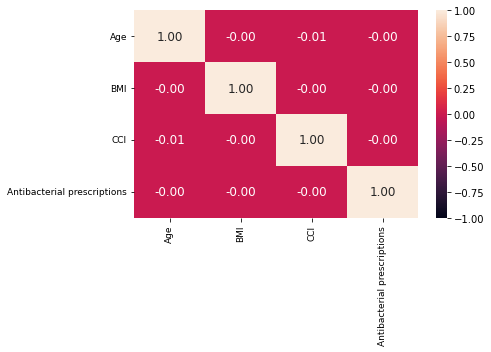

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_otmedia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_otmedia/corr_otmedia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_otmedia = data_otmedia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'otmedia_ab_date', 'ab_type_cat', 'incdt_otmedia_date', 'date', 'period',
                                   'event_otmedia_admitted', 'duration_otmedia_admitted'
                                    ]]

In [38]:
#incident and prevalent infection 
data_otmedia_incdt = data_otmedia[data_otmedia['incdt_otmedia_date'] == 0]
data_otmedia_prevl = data_otmedia[data_otmedia['incdt_otmedia_date'] == 1]
#switch variable otmedia_ab_date into a binary variable
data_otmedia_incdt[['otmedia_ab_date']] = data_otmedia_incdt[['otmedia_ab_date']].where(data_otmedia_incdt[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)
data_otmedia_prevl[['otmedia_ab_date']] = data_otmedia_prevl[['otmedia_ab_date']].where(data_otmedia_prevl[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_otmedia_incdt_males = data_otmedia_incdt[data_otmedia_incdt['sex'] == 'male']
data_otmedia_incdt_females = data_otmedia_incdt[data_otmedia_incdt['sex'] == 'female']
data_otmedia_prevl_males = data_otmedia_prevl[data_otmedia_prevl['sex'] == 'male']
data_otmedia_prevl_females = data_otmedia_prevl[data_otmedia_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_otmedia_incdt_15_24 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '15_24']
data_otmedia_incdt_25_34 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '25_34']
data_otmedia_incdt_35_44 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '35_44']
data_otmedia_incdt_45_54 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '45_54']
data_otmedia_incdt_55_64 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '55_64']
data_otmedia_incdt_65_74 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '65_74']
data_otmedia_incdt_75_more = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '75_more']
data_otmedia_prevl_15_24 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '15_24']
data_otmedia_prevl_25_34 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '25_34']
data_otmedia_prevl_35_44 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '35_44']
data_otmedia_prevl_45_54 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '45_54']
data_otmedia_prevl_55_64 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '55_64']
data_otmedia_prevl_65_74 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '65_74']
data_otmedia_prevl_75_more = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_otmedia_incdt_prepandemic = data_otmedia_incdt[data_otmedia_incdt['date'] <= '2019-12']
data_otmedia_incdt_during_pandemic = data_otmedia_incdt[(data_otmedia_incdt['date'] >= '2020-03') & (data_otmedia_incdt['date']<= '2021-03')]
data_otmedia_incdt_post_2nd_lockdown = data_otmedia_incdt[data_otmedia_incdt['date'] <= '2021-04']
data_otmedia_prevl_prepandemic = data_otmedia_prevl[data_otmedia_prevl['date'] <= '2019-12']
data_otmedia_prevl_during_pandemic = data_otmedia_prevl[(data_otmedia_prevl['date'] >= '2020-03') & (data_otmedia_prevl['date']<= '2021-03')]
data_otmedia_prevl_post_2nd_lockdown = data_otmedia_prevl[data_otmedia_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_otmedia_no_abs_incdt = data_otmedia[data_otmedia['otmedia_ab_date'].isnull()]
data_otmedia_no_abs_incdt = data_otmedia_no_abs_incdt[data_otmedia_no_abs_incdt['incdt_otmedia_date'] == 0]

# with antibiotics and incident hospital admission
data_otmedia_abs_incdt = data_otmedia[data_otmedia['otmedia_ab_date'].notnull()]
data_otmedia_abs_incdt = data_otmedia_abs_incdt[data_otmedia_abs_incdt['incdt_otmedia_date'] == 0]

# no antibiotics and prevalent hospital admission
data_otmedia_no_abs_prevl = data_otmedia[data_otmedia['otmedia_ab_date'].isnull()]
data_otmedia_no_abs_prevl = data_otmedia_no_abs_prevl[data_otmedia_no_abs_prevl['incdt_otmedia_date'] == 1]

# with antibiotics and prevalent hospital admission
data_otmedia_abs_prevl = data_otmedia[data_otmedia['otmedia_ab_date'].notnull()]
data_otmedia_abs_prevl = data_otmedia_abs_prevl[data_otmedia_abs_prevl['incdt_otmedia_date'] == 1]

In [ ]:
#store data for plotting hosp admission counts and percentages
%store data_otmedia
# save data
data_otmedia.to_csv('../output/hospitalisation_prediction_otmedia/data_otmedia.csv')

Stored 'data_otmedia' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident otmedia with no antibiotics

<lifelines.CoxPHFitter: fitted with 108667 total observations, 108006 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 108667
number of events observed = 661
   partial log-likelihood = -7649.73
         time fit was run = 2023-06-26 10:51:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.12            -0.27             0.19                 0.76                 1.21
CCI_cat[T.medium]                0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
CCI_cat[T.high]                  0.00       1.00       0.16            -0.30             0.30                 0.74                 1.36
CCI_cat[T.very_high]             0.12       1.13       0.13            -0.14             0.38                 0.87                 1.46
age_cat[T.25_34]                -0.07       0.93       0.14            -0.35             0.21                 0.70                 1.23
age_cat[T.35_44]                -0.01       0.99       0.14            -0.28             0.27                 0.75                 1.30
age_cat[T.45_54]                -0.13       0.88       0.15            -0.41             0.16                 0.66                 1.17
age_cat[T.55_64]                -0.14       0.87       0.15            -0.43             0.14                 0.65                 1.16
age_cat[T.65_74]                -0.12       0.89       0.14            -0.40             0.16                 0.67                 1.18
age_cat[T.75_more]              -0.07       0.93       0.14            -0.35             0.21                 0.71                 1.24
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.04                 0.94                 1.04
bmi_cat[T.obese]                 0.14       1.15       0.15            -0.16             0.44                 0.85                 1.55
bmi_cat[T.overweight]            0.16       1.17       0.18            -0.20             0.52                 0.82                 1.68
bmi_cat[T.underweight]           0.11       1.11       0.26            -0.40             0.61                 0.67                 1.85
bmi_cat[T.unknown]               0.06       1.06       0.16            -0.27             0.38                 0.77                 1.46
ethnicity[T.unknown]             0.19       1.21       0.13            -0.05             0.44                 0.95                 1.55
ethnicity[T.white]              -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.24
flu_vaccine[T.yes]              -0.05       0.95       0.13            -0.31             0.21                 0.74                 1.23
imd[T.medium]                   -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
imd[T.unaffluent]               -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
imd[T.unknown]                  -0.27       0.76       0.22            -0.70             0.16                 0.50                 1.17
imd[T.very_affluent]             0.06       1.06       0.13            -0.19             0.30                 0.83                 1.35
imd[T.very_unaffluent]           0.09       1.09       0.12            -0.15             0.33                 0.86                 1.39
region[T.east_midlands]         -0.11       0.90       0.17            -0.44             0.22                 0.65                 1.25
region[T.london]                -0.15       0.86       0.14

12785


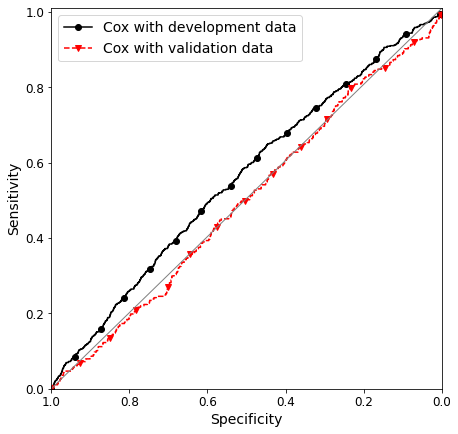

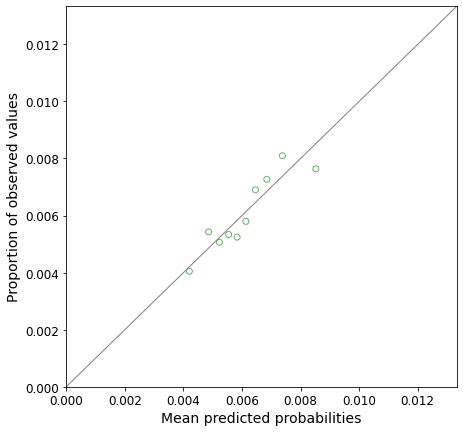

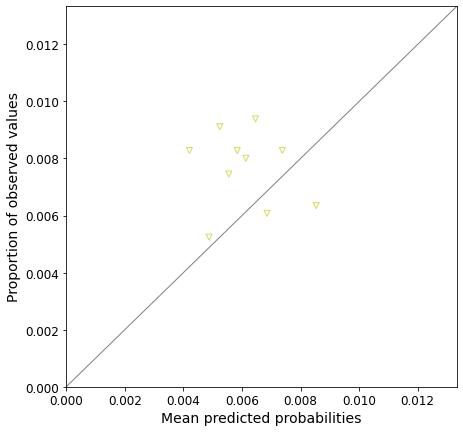

In [ ]:
#data prep
data, data_otmedia_no_abs_incdt_enc = cox_data_prep(data_otmedia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt)

try:
    #build cox model 
    cph_otmedia_no_abs_incdt, data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test = cox_model_build('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_otmedia_no_abs_incdt, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_no_abs_incdt.csv', data_otmedia_no_abs_incdt_enc, data_otmedia_no_abs_incdt, 'sum_betas_cph_otmedia_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_otmedia_no_abs_incdt, 'event_otmedia_admitted', data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_otmedia_no_abs_incdt, data_otmedia_no_abs_incdt_train, 'event_otmedia_admitted', data_otmedia_no_abs_incdt_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_no_abs_incdt_train.jpg', 'calibration_cph_otmedia_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_no_abs_incdt, 'otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident otmedia with antibiotics

<lifelines.CoxPHFitter: fitted with 12038 total observations, 11952 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 12038
number of events observed = 86
   partial log-likelihood = -786.92
         time fit was run = 2023-06-26 10:52:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.30            -0.51             0.67                 0.60                 1.96
CCI_cat[T.medium]               -0.40       0.67       0.37            -1.13             0.34                 0.32                 1.40
CCI_cat[T.high]                 -0.02       0.98       0.42            -0.84             0.80                 0.43                 2.22
CCI_cat[T.very_high]            -0.24       0.79       0.38            -0.99             0.51                 0.37                 1.67
age_cat[T.25_34]                 0.92       2.51       0.45             0.03             1.81                 1.03                 6.11
age_cat[T.35_44]                 0.10       1.10       0.52            -0.92             1.11                 0.40                 3.04
age_cat[T.45_54]                 0.21       1.23       0.50            -0.78             1.19                 0.46                 3.30
age_cat[T.55_64]                 1.00       2.71       0.45             0.12             1.87                 1.13                 6.50
age_cat[T.65_74]                 0.72       2.05       0.46            -0.19             1.63                 0.83                 5.09
age_cat[T.75_more]               0.68       1.98       0.46            -0.23             1.59                 0.80                 4.91
antibacterial_brit              -0.01       0.99       0.08            -0.16             0.14                 0.85                 1.15
bmi_cat[T.obese]                 0.21       1.23       0.44            -0.64             1.06                 0.53                 2.90
bmi_cat[T.overweight]            0.09       1.10       0.53            -0.94             1.13                 0.39                 3.09
bmi_cat[T.underweight]          -0.12       0.89       0.82            -1.72             1.48                 0.18                 4.40
bmi_cat[T.unknown]               0.27       1.31       0.46            -0.62             1.17                 0.54                 3.22
ethnicity[T.unknown]             0.14       1.15       0.36            -0.56             0.84                 0.57                 2.31
ethnicity[T.white]               0.05       1.05       0.32            -0.58             0.68                 0.56                 1.97
flu_vaccine[T.yes]               0.03       1.03       0.35            -0.67             0.72                 0.51                 2.05
imd[T.medium]                    0.45       1.57       0.38            -0.30             1.20                 0.74                 3.32
imd[T.unaffluent]                0.05       1.05       0.42            -0.77             0.87                 0.46                 2.39
imd[T.unknown]                   0.50       1.64       0.54            -0.56             1.56                 0.57                 4.75
imd[T.very_affluent]             0.46       1.59       0.38            -0.29             1.21                 0.75                 3.36
imd[T.very_unaffluent]           0.66       1.94       0.37            -0.06             1.39                 0.94                 4.00
region[T.east_midlands]          0.76       2.13       0.54            -0.30             1.82                 0.74                 6.15
region[T.london]                 0.71       2.04       0.50     

12754


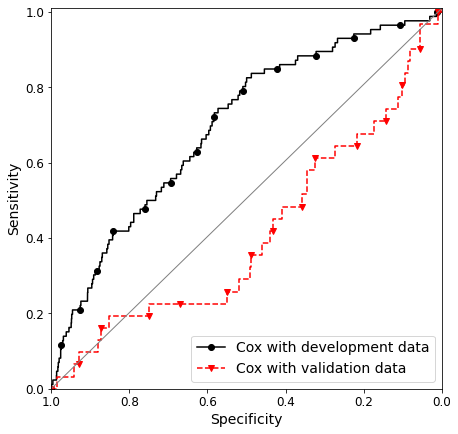

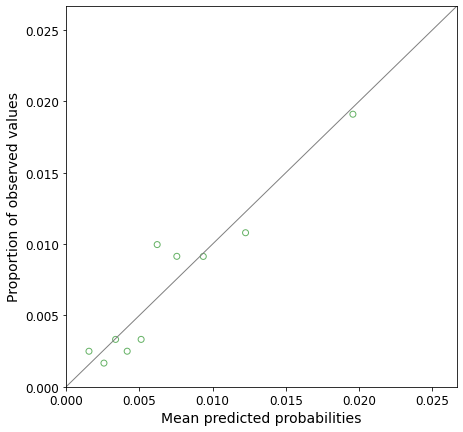

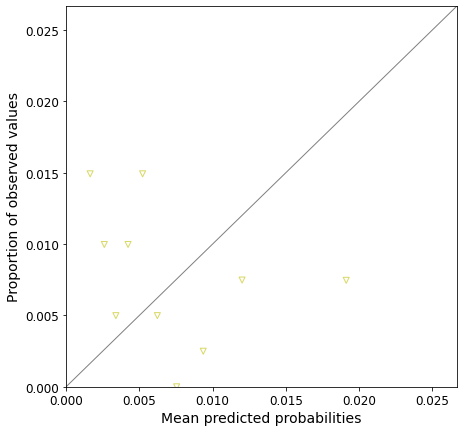

In [ ]:
#data prep
data, data_otmedia_abs_incdt_enc = cox_data_prep(data_otmedia_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'abs_incdt', data_otmedia_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'abs_incdt', data_otmedia_abs_incdt)

try:
    #build cox model 
    cph_otmedia_abs_incdt, data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test = cox_model_build('otmedia', 'abs_incdt', data_otmedia_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_otmedia_abs_incdt, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_abs_incdt.csv', data_otmedia_abs_incdt_enc, data_otmedia_abs_incdt, 'sum_betas_cph_otmedia_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_otmedia_abs_incdt, 'event_otmedia_admitted', data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_otmedia_abs_incdt, data_otmedia_abs_incdt_train, 'event_otmedia_admitted', data_otmedia_abs_incdt_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_abs_incdt_train.jpg', 'calibration_cph_otmedia_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_abs_incdt, 'otmedia', 'abs_incdt', data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent otmedia with no antibiotics

<lifelines.CoxPHFitter: fitted with 12003 total observations, 11922 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 12003
number of events observed = 81
   partial log-likelihood = -739.36
         time fit was run = 2023-06-26 10:52:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.30            -0.80             0.40                 0.45                 1.49
CCI_cat[T.medium]               -0.32       0.73       0.35            -1.00             0.37                 0.37                 1.45
CCI_cat[T.high]                 -0.32       0.73       0.43            -1.16             0.52                 0.31                 1.68
CCI_cat[T.very_high]            -0.59       0.56       0.40            -1.37             0.20                 0.25                 1.22
age_cat[T.25_34]                 0.62       1.85       0.56            -0.48             1.71                 0.62                 5.54
age_cat[T.35_44]                 0.85       2.35       0.54            -0.20             1.91                 0.81                 6.76
age_cat[T.45_54]                 1.21       3.36       0.51             0.21             2.22                 1.23                 9.17
age_cat[T.55_64]                 1.34       3.83       0.51             0.35             2.33                 1.42                10.32
age_cat[T.65_74]                 1.05       2.85       0.52             0.03             2.07                 1.03                 7.93
age_cat[T.75_more]               0.46       1.58       0.57            -0.66             1.58                 0.52                 4.85
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                 0.13       1.14       0.44            -0.73             0.98                 0.48                 2.67
bmi_cat[T.overweight]            0.22       1.24       0.52            -0.80             1.23                 0.45                 3.43
bmi_cat[T.underweight]           0.15       1.16       0.71            -1.24             1.54                 0.29                 4.64
bmi_cat[T.unknown]               0.01       1.01       0.47            -0.91             0.93                 0.40                 2.52
ethnicity[T.unknown]            -0.28       0.76       0.37            -1.00             0.45                 0.37                 1.57
ethnicity[T.white]              -0.03       0.97       0.31            -0.64             0.58                 0.53                 1.78
flu_vaccine[T.yes]              -0.02       0.98       0.37            -0.75             0.71                 0.47                 2.04
imd[T.medium]                    0.39       1.47       0.35            -0.30             1.07                 0.74                 2.92
imd[T.unaffluent]               -0.14       0.87       0.39            -0.91             0.63                 0.40                 1.88
imd[T.unknown]                  -1.32       0.27       1.04            -3.35             0.70                 0.03                 2.02
imd[T.very_affluent]             0.41       1.51       0.35            -0.27             1.09                 0.76                 2.98
imd[T.very_unaffluent]           0.01       1.01       0.38            -0.74             0.75                 0.48                 2.11
region[T.east_midlands]          0.72       2.06       0.55            -0.35             1.80                 0.70                 6.04
region[T.london]                 0.72       2.05       0.50     

12762


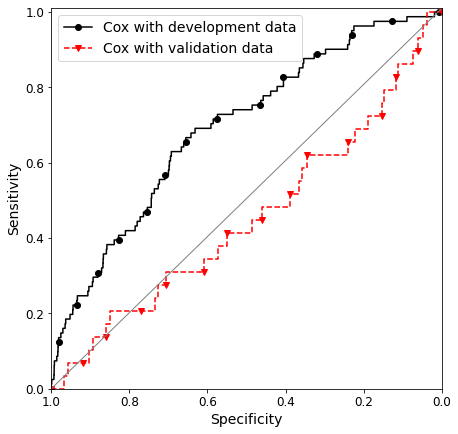

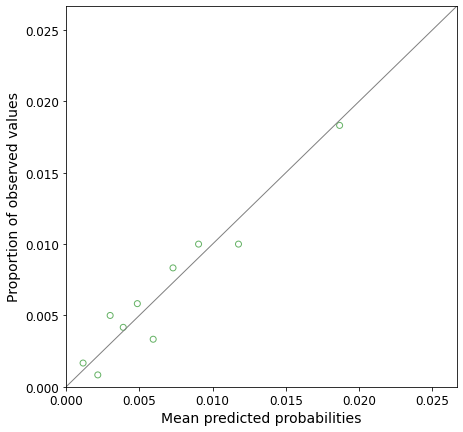

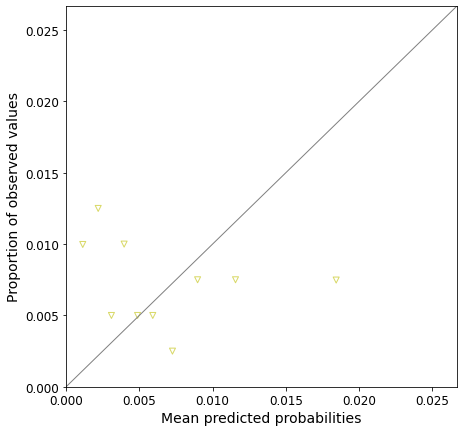

In [ ]:
#data prep
data, data_otmedia_no_abs_prevl_enc = cox_data_prep(data_otmedia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl)

try:
    #build cox model 
    cph_otmedia_no_abs_prevl, data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test = cox_model_build('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_otmedia_no_abs_prevl, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_no_abs_prevl.csv', data_otmedia_no_abs_prevl_enc, data_otmedia_no_abs_prevl, 'sum_betas_cph_otmedia_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_otmedia_no_abs_prevl, 'event_otmedia_admitted', data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_otmedia_no_abs_prevl, data_otmedia_no_abs_prevl_train, 'event_otmedia_admitted', data_otmedia_no_abs_prevl_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_no_abs_prevl_train.jpg', 'calibration_cph_otmedia_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_no_abs_prevl, 'otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent otmedia with antibiotics

<lifelines.CoxPHFitter: fitted with 1278 total observations, 1276 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1278
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2023-06-26 10:52:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   3.43      30.86   29447.95        -57713.49         57720.35                 0.00                  inf
CCI_cat[T.medium]               -6.11       0.00   32771.72        -64237.50         64225.28                 0.00                  inf
CCI_cat[T.high]                 11.68   1.18e+05   21772.26        -42661.17         42684.52                 0.00                  inf
CCI_cat[T.very_high]             9.47   12974.67   24967.10        -48925.14         48944.08                 0.00                  inf
age_cat[T.25_34]                -3.44       0.03   33609.38        -65876.61         65869.73                 0.00                  inf
age_cat[T.35_44]               -11.50       0.00   43987.99        -86226.37         86203.37                 0.00                  inf
age_cat[T.45_54]                 1.68       5.38   22577.28        -44248.98         44252.35                 0.00                  inf
age_cat[T.55_64]               -15.10       0.00   35616.17        -69821.51         69791.31                 0.00                  inf
age_cat[T.65_74]                -8.33       0.00   31601.23        -61945.60         61928.94                 0.00                  inf
age_cat[T.75_more]              -8.70       0.00   39825.22        -78064.71         78047.30                 0.00                  inf
antibacterial_brit              -2.37       0.09   11770.36        -23071.85         23067.11                 0.00                  inf
bmi_cat[T.obese]                 6.50     663.76   90775.11       -177909.46        177922.45                 0.00                  inf
bmi_cat[T.overweight]            0.89       2.43   96347.31       -188836.38        188838.15                 0.00                  inf
bmi_cat[T.underweight]          21.63   2.48e+09   79646.63       -156082.89        156126.16                 0.00                  inf
bmi_cat[T.unknown]               5.42     226.23   83843.58       -164324.97        164335.81                 0.00                  inf
ethnicity[T.unknown]             7.18    1309.80   20731.78        -40626.37         40640.72                 0.00                  inf
ethnicity[T.white]              -4.41       0.01   24972.07        -48948.77         48939.96                 0.00                  inf
flu_vaccine[T.yes]              -3.19       0.04   68145.81       -133566.53        133560.14                 0.00                  inf
imd[T.medium]                   -6.30       0.00   39149.45        -76737.81         76725.22                 0.00                  inf
imd[T.unaffluent]                3.44      31.24   25424.35        -49827.38         49834.26                 0.00                  inf
imd[T.unknown]                  -5.57       0.00   63169.79       -123816.08        123804.94                 0.00                  inf
imd[T.very_affluent]             3.21      24.81   27824.86        -54532.50         54538.93                 0.00                  inf
imd[T.very_unaffluent]           1.77       5.86   28006.10        -54889.19         54892.72                 0.00                  inf
region[T.east_midlands]          0.26       1.29   31257.56        -61263.44         61263.95                 0.00                  inf
region[T.london]                 4.29      72.98   31794.21        -62

13237


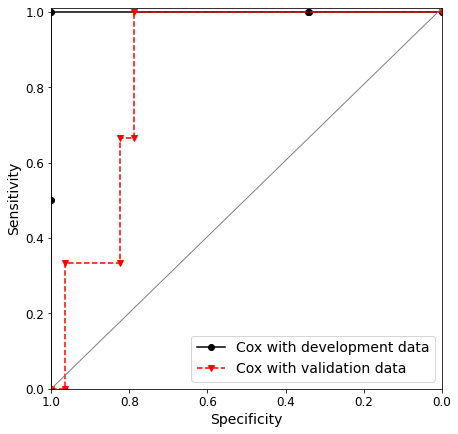

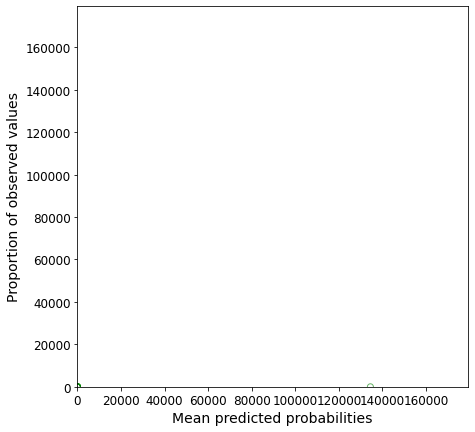

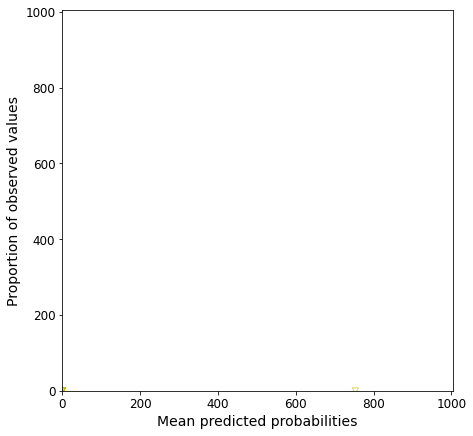

In [ ]:
#data prep
data, data_otmedia_abs_prevl_enc = cox_data_prep(data_otmedia_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'abs_prevl', data_otmedia_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'abs_prevl', data_otmedia_abs_prevl)

try:
    #build cox model 
    cph_otmedia_abs_prevl, data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test = cox_model_build('otmedia', 'abs_prevl', data_otmedia_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_otmedia_abs_prevl, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_abs_prevl.csv', data_otmedia_abs_prevl_enc, data_otmedia_abs_prevl, 'sum_betas_cph_otmedia_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_otmedia_abs_prevl, 'event_otmedia_admitted', data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_otmedia_abs_prevl, data_otmedia_abs_prevl_train, 'event_otmedia_admitted', data_otmedia_abs_prevl_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_abs_prevl_train.jpg', 'calibration_cph_otmedia_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_abs_prevl, 'otmedia', 'abs_prevl', data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident otmedia

In [ ]:
#data prep
data, data_otmedia_incdt_enc = cox_data_prep(data_otmedia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary tables from preped data
make_summary_table('otmedia', 'incdt', data_otmedia_incdt_enc)
make_summary_table_hosped('otmedia', 'incdt', data_otmedia_incdt)

try:
    cph_otmedia_incdt, data_otmedia_incdt_train, data_otmedia_incdt_test = cox_model_abs_build('otmedia', 'incdt', data_otmedia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt, 'otmedia', 'incdt', data_otmedia_incdt_train, data_otmedia_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120705 total observations, 119891 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 120705
number of events observed = 814
   partial log-likelihood = -9508.69
         time fit was run = 2023-06-26 10:52:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.10            -0.26             0.15                 0.77                 1.17
CCI_cat[T.medium]                0.01       1.01       0.11            -0.21             0.24                 0.81                 1.27
CCI_cat[T.high]                 -0.00       1.00       0.14            -0.27             0.27                 0.76                 1.31
CCI_cat[T.very_high]             0.06       1.06       0.12            -0.17             0.30                 0.84                 1.34
age_cat[T.25_34]                -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.28
age_cat[T.35_44]                 0.03       1.03       0.13            -0.22             0.29                 0.80                 1.33
age_cat[T.45_54]                 0.02       1.02       0.13            -0.23             0.28                 0.79                 1.32
age_cat[T.55_64]                 0.02       1.02       0.13            -0.24             0.28                 0.79                 1.32
age_cat[T.65_74]                 0.00       1.00       0.13            -0.26             0.26                 0.77                 1.29
age_cat[T.75_more]              -0.10       0.91       0.13            -0.36             0.17                 0.70                 1.18
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.02                 0.93                 1.02
bmi_cat[T.obese]                 0.18       1.19       0.14            -0.10             0.45                 0.91                 1.57
bmi_cat[T.overweight]            0.13       1.14       0.17            -0.19             0.46                 0.82                 1.59
bmi_cat[T.underweight]          -0.01       0.99       0.24            -0.48             0.47                 0.62                 1.60
bmi_cat[T.unknown]               0.07       1.07       0.15            -0.23             0.36                 0.80                 1.44
ethnicity[T.unknown]             0.01       1.01       0.11            -0.21             0.23                 0.81                 1.26
ethnicity[T.white]              -0.06       0.95       0.10            -0.25             0.14                 0.78                 1.15
flu_vaccine[T.yes]              -0.06       0.95       0.12            -0.29             0.18                 0.75                 1.19
imd[T.medium]                    0.12       1.12       0.11            -0.11             0.34                 0.90                 1.40
imd[T.unaffluent]                0.02       1.02       0.12            -0.21             0.25                 0.81                 1.28
imd[T.unknown]                  -0.06       0.94       0.19            -0.42             0.31                 0.65                 1.36
imd[T.very_affluent]             0.02       1.02       0.12            -0.21             0.25                 0.81                 1.29
imd[T.very_unaffluent]           0.21       1.23       0.11            -0.01             0.43                 0.99                 1.53
otmedia_ab_date                  0.19       1.21       0.11            -0.03             0.40                 0.97                 1.49
region[T.east_midlands]         -0.06       0.94       0.15

13045


### 5-6- hospital admission related to prevalent otmedia

In [ ]:
#data prep
data, data_otmedia_prevl_enc = cox_data_prep(data_otmedia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary tables from preped data
make_summary_table('otmedia', 'prevl', data_otmedia_prevl_enc)
make_summary_table_hosped('otmedia', 'prevl', data_otmedia_prevl)

try:
    cph_otmedia_prevl, data_otmedia_prevl_train, data_otmedia_prevl_test = cox_model_abs_build('otmedia', 'prevl', data_otmedia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl, 'otmedia', 'prevl', data_otmedia_prevl_train, data_otmedia_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13282 total observations, 13198 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 13282
number of events observed = 84
   partial log-likelihood = -775.54
         time fit was run = 2023-06-26 10:52:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.30            -0.69             0.49                 0.50                 1.63
CCI_cat[T.medium]               -0.11       0.90       0.33            -0.76             0.55                 0.47                 1.73
CCI_cat[T.high]                 -0.42       0.66       0.45            -1.30             0.47                 0.27                 1.59
CCI_cat[T.very_high]            -0.75       0.47       0.43            -1.60             0.09                 0.20                 1.09
age_cat[T.25_34]                -0.08       0.93       0.49            -1.03             0.88                 0.36                 2.40
age_cat[T.35_44]                 0.26       1.30       0.45            -0.62             1.14                 0.54                 3.13
age_cat[T.45_54]                 0.77       2.17       0.40            -0.01             1.56                 0.99                 4.76
age_cat[T.55_64]                 0.40       1.50       0.43            -0.45             1.25                 0.64                 3.50
age_cat[T.65_74]                 0.52       1.67       0.42            -0.31             1.34                 0.73                 3.83
age_cat[T.75_more]              -0.11       0.89       0.49            -1.07             0.84                 0.34                 2.32
antibacterial_brit               0.05       1.06       0.08            -0.09             0.20                 0.91                 1.22
bmi_cat[T.obese]                 0.38       1.47       0.47            -0.54             1.31                 0.58                 3.70
bmi_cat[T.overweight]            0.40       1.49       0.55            -0.68             1.47                 0.51                 4.37
bmi_cat[T.underweight]           0.68       1.97       0.67            -0.64             2.00                 0.53                 7.37
bmi_cat[T.unknown]               0.19       1.21       0.50            -0.80             1.17                 0.45                 3.24
ethnicity[T.unknown]             0.06       1.06       0.38            -0.68             0.80                 0.51                 2.22
ethnicity[T.white]               0.18       1.19       0.33            -0.47             0.83                 0.62                 2.29
flu_vaccine[T.yes]               0.17       1.18       0.34            -0.49             0.83                 0.61                 2.30
imd[T.medium]                    0.44       1.56       0.36            -0.26             1.14                 0.77                 3.13
imd[T.unaffluent]                0.18       1.20       0.38            -0.56             0.93                 0.57                 2.53
imd[T.unknown]                  -1.24       0.29       1.04            -3.27             0.80                 0.04                 2.22
imd[T.very_affluent]             0.50       1.64       0.36            -0.20             1.20                 0.82                 3.31
imd[T.very_unaffluent]           0.15       1.16       0.38            -0.59             0.89                 0.55                 2.45
otmedia_ab_date                 -1.46       0.23       0.72            -2.86            -0.06                 0.06                 0.95
region[T.east_midlands]          0.33       1.39       0.54     

13032


### 5-7- hospital admission related to incident otmedia with prescribed antibiotics categories

In [ ]:
#data prep
data, data_otmedia_incdt_abs_enc = cox_data_prep(data_otmedia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_abs, data_otmedia_incdt_abs_train, data_otmedia_incdt_abs_test = cox_model_ab_type_build('otmedia', 'incdt_ab_type', data_otmedia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_abs, 'otmedia', 'incdt_abs', data_otmedia_incdt_abs_train, data_otmedia_incdt_abs_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120705 total observations, 119891 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 120705
number of events observed = 814
   partial log-likelihood = -9507.78
         time fit was run = 2023-06-26 10:52:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.10            -0.26             0.15                 0.77                 1.17
CCI_cat[T.medium]                0.01       1.01       0.11            -0.21             0.23                 0.81                 1.26
CCI_cat[T.high]                 -0.00       1.00       0.14            -0.27             0.27                 0.76                 1.31
CCI_cat[T.very_high]             0.06       1.06       0.12            -0.17             0.30                 0.84                 1.34
ab_type_cat[T.Doxycycline]       0.84       2.32       0.67            -0.47             2.16                 0.62                 8.66
ab_type_cat[T.no]               -0.08       0.92       0.45            -0.96             0.80                 0.38                 2.22
ab_type_cat[T.other]             0.09       1.09       0.46            -0.82             0.99                 0.44                 2.69
age_cat[T.25_34]                -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.28
age_cat[T.35_44]                 0.03       1.04       0.13            -0.22             0.29                 0.80                 1.33
age_cat[T.45_54]                 0.02       1.02       0.13            -0.23             0.28                 0.79                 1.32
age_cat[T.55_64]                 0.02       1.02       0.13            -0.24             0.28                 0.79                 1.32
age_cat[T.65_74]                 0.00       1.00       0.13            -0.26             0.26                 0.77                 1.29
age_cat[T.75_more]              -0.10       0.91       0.13            -0.36             0.17                 0.70                 1.18
antibacterial_brit              -0.03       0.97       0.02            -0.08             0.02                 0.93                 1.02
bmi_cat[T.obese]                 0.18       1.19       0.14            -0.10             0.45                 0.91                 1.57
bmi_cat[T.overweight]            0.14       1.15       0.17            -0.19             0.46                 0.83                 1.59
bmi_cat[T.underweight]          -0.01       0.99       0.24            -0.48             0.47                 0.62                 1.60
bmi_cat[T.unknown]               0.07       1.07       0.15            -0.22             0.36                 0.80                 1.44
ethnicity[T.unknown]             0.01       1.01       0.11            -0.21             0.23                 0.81                 1.26
ethnicity[T.white]              -0.06       0.95       0.10            -0.25             0.14                 0.78                 1.15
flu_vaccine[T.yes]              -0.06       0.94       0.12            -0.29             0.18                 0.75                 1.19
imd[T.medium]                    0.12       1.12       0.11            -0.11             0.34                 0.90                 1.41
imd[T.unaffluent]                0.02       1.02       0.12            -0.21             0.25                 0.81                 1.28
imd[T.unknown]                  -0.06       0.94       0.19            -0.42             0.31                 0.65                 1.36
imd[T.very_affluent]             0.02       1.02       0.12

13607


### 5-8- hospital admission related to prevalent otmedia with prescribed antibiotics categories

In [ ]:
#data prep
data, data_otmedia_prevl_abs_enc = cox_data_prep(data_otmedia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_abs, data_otmedia_prevl_abs_train, data_otmedia_prevl_abs_test = cox_model_ab_type_build('otmedia', 'prevl_ab_type', data_otmedia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_abs, 'otmedia', 'prevl_abs', data_otmedia_prevl_abs_train, data_otmedia_prevl_abs_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13282 total observations, 13198 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 13282
number of events observed = 84
   partial log-likelihood = -775.41
         time fit was run = 2023-06-26 10:53:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.30            -0.68             0.49                 0.50                 1.63
CCI_cat[T.medium]               -0.10       0.90       0.33            -0.76             0.55                 0.47                 1.73
CCI_cat[T.high]                 -0.42       0.66       0.45            -1.30             0.47                 0.27                 1.59
CCI_cat[T.very_high]            -0.75       0.47       0.43            -1.60             0.09                 0.20                 1.09
ab_type_cat[T.Doxycycline]       0.38       1.47    4587.67         -8991.29          8992.06                 0.00                  inf
ab_type_cat[T.no]               14.70   2.43e+06    2307.87         -4508.64          4538.05                 0.00                  inf
ab_type_cat[T.other]            13.31   6.05e+05    2307.87         -4510.03          4536.66                 0.00                  inf
age_cat[T.25_34]                -0.08       0.93       0.49            -1.03             0.88                 0.36                 2.40
age_cat[T.35_44]                 0.26       1.29       0.45            -0.62             1.14                 0.54                 3.13
age_cat[T.45_54]                 0.77       2.16       0.40            -0.02             1.56                 0.98                 4.76
age_cat[T.55_64]                 0.40       1.49       0.43            -0.45             1.25                 0.64                 3.50
age_cat[T.65_74]                 0.51       1.67       0.42            -0.31             1.34                 0.73                 3.83
age_cat[T.75_more]              -0.11       0.89       0.49            -1.07             0.84                 0.34                 2.32
antibacterial_brit               0.05       1.06       0.08            -0.09             0.20                 0.91                 1.22
bmi_cat[T.obese]                 0.38       1.47       0.47            -0.54             1.31                 0.58                 3.70
bmi_cat[T.overweight]            0.40       1.49       0.55            -0.68             1.47                 0.51                 4.37
bmi_cat[T.underweight]           0.68       1.97       0.67            -0.64             2.00                 0.53                 7.37
bmi_cat[T.unknown]               0.19       1.21       0.50            -0.80             1.18                 0.45                 3.24
ethnicity[T.unknown]             0.06       1.06       0.38            -0.68             0.80                 0.51                 2.22
ethnicity[T.white]               0.18       1.19       0.33            -0.47             0.83                 0.62                 2.29
flu_vaccine[T.yes]               0.17       1.18       0.34            -0.49             0.83                 0.61                 2.30
imd[T.medium]                    0.44       1.56       0.36            -0.26             1.14                 0.77                 3.13
imd[T.unaffluent]                0.18       1.20       0.38            -0.56             0.93                 0.57                 2.53
imd[T.unknown]                  -1.24       0.29       1.04            -3.27             0.80                 0.04                 2.22
imd[T.very_affluent]             0.50       1.65       0.36     

13623


### 5-9- stratified by sex
#### 5-9-1- incident males

In [ ]:
#data prep
data, data_otmedia_incdt_males_enc = cox_data_prep(data_otmedia_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_males, data_otmedia_incdt_males_train, data_otmedia_incdt_males_test = cox_model_strat_sex_build('otmedia', 'incdt_males', data_otmedia_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_males, 'otmedia', 'incdt_males', data_otmedia_incdt_males_train, data_otmedia_incdt_males_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58758 total observations, 58388 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 58758
number of events observed = 370
   partial log-likelihood = -4046.50
         time fit was run = 2023-06-26 10:53:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.15            -0.35             0.24                 0.70                 1.28
CCI_cat[T.medium]               -0.17       0.84       0.17            -0.51             0.17                 0.60                 1.18
CCI_cat[T.high]                  0.08       1.08       0.19            -0.30             0.46                 0.74                 1.58
CCI_cat[T.very_high]            -0.11       0.89       0.18            -0.47             0.24                 0.63                 1.27
age_cat[T.25_34]                 0.04       1.04       0.19            -0.32             0.40                 0.72                 1.49
age_cat[T.35_44]                -0.11       0.90       0.19            -0.48             0.27                 0.62                 1.31
age_cat[T.45_54]                -0.15       0.86       0.19            -0.54             0.23                 0.59                 1.25
age_cat[T.55_64]                -0.02       0.98       0.19            -0.39             0.35                 0.68                 1.42
age_cat[T.65_74]                -0.11       0.90       0.19            -0.48             0.27                 0.62                 1.31
age_cat[T.75_more]              -0.17       0.84       0.20            -0.56             0.21                 0.57                 1.23
antibacterial_brit              -0.05       0.95       0.04            -0.12             0.02                 0.88                 1.02
bmi_cat[T.obese]                 0.36       1.44       0.22            -0.08             0.80                 0.92                 2.23
bmi_cat[T.overweight]            0.47       1.60       0.26            -0.03             0.98                 0.97                 2.66
bmi_cat[T.underweight]           0.13       1.14       0.38            -0.61             0.88                 0.54                 2.42
bmi_cat[T.unknown]               0.32       1.38       0.24            -0.14             0.79                 0.87                 2.20
ethnicity[T.unknown]             0.22       1.24       0.17            -0.12             0.56                 0.89                 1.75
ethnicity[T.white]               0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
flu_vaccine[T.yes]              -0.12       0.89       0.18            -0.47             0.24                 0.63                 1.27
imd[T.medium]                    0.08       1.08       0.17            -0.25             0.40                 0.78                 1.50
imd[T.unaffluent]                0.07       1.08       0.17            -0.25             0.40                 0.78                 1.49
imd[T.unknown]                  -0.34       0.71       0.30            -0.93             0.25                 0.39                 1.28
imd[T.very_affluent]            -0.06       0.94       0.17            -0.40             0.28                 0.67                 1.32
imd[T.very_unaffluent]           0.04       1.04       0.17            -0.29             0.37                 0.75                 1.44
otmedia_ab_date                 -0.28       0.75       0.19            -0.66             0.10                 0.52                 1.10
region[T.east_midlands]         -0.24       0.79       0.22   

12797


#### 5-9-2- incident females

In [ ]:
#data prep
data, data_otmedia_incdt_females_enc = cox_data_prep(data_otmedia_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_females, data_otmedia_incdt_females_train, data_otmedia_incdt_females_test = cox_model_strat_sex_build('otmedia', 'incdt_females', data_otmedia_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_females, 'otmedia', 'incdt_females', data_otmedia_incdt_females_train, data_otmedia_incdt_females_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61947 total observations, 61544 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 61947
number of events observed = 403
   partial log-likelihood = -4431.11
         time fit was run = 2023-06-26 10:53:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.15            -0.39             0.21                 0.68                 1.24
CCI_cat[T.medium]                0.08       1.08       0.16            -0.24             0.40                 0.79                 1.49
CCI_cat[T.high]                  0.16       1.17       0.19            -0.22             0.53                 0.81                 1.71
CCI_cat[T.very_high]             0.18       1.20       0.17            -0.15             0.51                 0.86                 1.67
age_cat[T.25_34]                -0.05       0.95       0.19            -0.42             0.31                 0.65                 1.37
age_cat[T.35_44]                 0.06       1.06       0.18            -0.29             0.42                 0.75                 1.52
age_cat[T.45_54]                -0.15       0.86       0.19            -0.53             0.23                 0.59                 1.26
age_cat[T.55_64]                -0.00       1.00       0.19            -0.37             0.36                 0.69                 1.44
age_cat[T.65_74]                 0.01       1.01       0.18            -0.35             0.38                 0.71                 1.46
age_cat[T.75_more]              -0.02       0.98       0.19            -0.39             0.34                 0.68                 1.41
antibacterial_brit               0.00       1.00       0.04            -0.07             0.07                 0.93                 1.07
bmi_cat[T.obese]                 0.00       1.00       0.19            -0.36             0.37                 0.70                 1.45
bmi_cat[T.overweight]           -0.02       0.98       0.23            -0.47             0.42                 0.62                 1.53
bmi_cat[T.underweight]          -0.05       0.96       0.33            -0.69             0.60                 0.50                 1.82
bmi_cat[T.unknown]              -0.09       0.91       0.20            -0.49             0.31                 0.61                 1.36
ethnicity[T.unknown]             0.16       1.17       0.16            -0.16             0.47                 0.85                 1.60
ethnicity[T.white]               0.01       1.01       0.15            -0.28             0.29                 0.76                 1.34
flu_vaccine[T.yes]              -0.19       0.83       0.18            -0.54             0.16                 0.58                 1.18
imd[T.medium]                   -0.03       0.97       0.17            -0.36             0.29                 0.70                 1.34
imd[T.unaffluent]               -0.02       0.98       0.17            -0.34             0.30                 0.71                 1.36
imd[T.unknown]                  -0.01       0.99       0.26            -0.52             0.49                 0.60                 1.63
imd[T.very_affluent]             0.03       1.04       0.16            -0.29             0.36                 0.75                 1.43
imd[T.very_unaffluent]           0.20       1.22       0.16            -0.11             0.50                 0.89                 1.66
otmedia_ab_date                  0.27       1.32       0.15            -0.02             0.57                 0.98                 1.77
region[T.east_midlands]         -0.13       0.88       0.22   

12776


#### 5-9-3- prevalent males

In [ ]:
#data prep
data, data_otmedia_prevl_males_enc = cox_data_prep(data_otmedia_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_males, data_otmedia_prevl_males_train, data_otmedia_prevl_males_test = cox_model_strat_sex_build('otmedia', 'prevl_males', data_otmedia_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_males, 'otmedia', 'prevl_males', data_otmedia_prevl_males_train, data_otmedia_prevl_males_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6425 total observations, 6386 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 6425
number of events observed = 39
   partial log-likelihood = -325.06
         time fit was run = 2023-06-26 10:53:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.53            -0.88             1.20                 0.42                 3.30
CCI_cat[T.medium]                0.77       2.17       0.53            -0.26             1.81                 0.77                 6.11
CCI_cat[T.high]                  0.21       1.24       0.67            -1.11             1.53                 0.33                 4.64
CCI_cat[T.very_high]            -0.23       0.80       0.67            -1.55             1.09                 0.21                 2.98
age_cat[T.25_34]                -0.30       0.74       0.92            -2.09             1.50                 0.12                 4.47
age_cat[T.35_44]                 0.38       1.46       0.77            -1.12             1.88                 0.33                 6.56
age_cat[T.45_54]                 1.23       3.41       0.66            -0.07             2.52                 0.93                12.46
age_cat[T.55_64]                 0.43       1.53       0.77            -1.07             1.93                 0.34                 6.88
age_cat[T.65_74]                 1.02       2.77       0.68            -0.31             2.35                 0.73                10.46
age_cat[T.75_more]               1.06       2.90       0.68            -0.27             2.39                 0.77                10.96
antibacterial_brit               0.01       1.01       0.11            -0.21             0.23                 0.81                 1.26
bmi_cat[T.obese]                 0.40       1.49       0.75            -1.06             1.86                 0.34                 6.42
bmi_cat[T.overweight]            0.96       2.62       0.80            -0.61             2.54                 0.54                12.67
bmi_cat[T.underweight]         -15.41       0.00    2524.45         -4963.24          4932.42                 0.00                  inf
bmi_cat[T.unknown]               0.55       1.73       0.77            -0.96             2.06                 0.38                 7.85
ethnicity[T.unknown]            -0.43       0.65       0.54            -1.48             0.63                 0.23                 1.87
ethnicity[T.white]              -0.04       0.97       0.43            -0.88             0.81                 0.41                 2.24
flu_vaccine[T.yes]               0.38       1.46       0.48            -0.57             1.32                 0.57                 3.75
imd[T.medium]                   -0.18       0.83       0.51            -1.18             0.81                 0.31                 2.25
imd[T.unaffluent]                0.02       1.02       0.47            -0.91             0.95                 0.40                 2.58
imd[T.unknown]                  -0.09       0.91       0.78            -1.63             1.45                 0.20                 4.25
imd[T.very_affluent]            -0.29       0.75       0.53            -1.33             0.74                 0.26                 2.11
imd[T.very_unaffluent]          -0.33       0.72       0.53            -1.37             0.71                 0.26                 2.03
otmedia_ab_date                 -1.46       0.23       1.01            -3.45             0.53                 0.03                 1.69
region[T.east_midlands]         -0.14       0.87       0.67        

12787


#### 5-9-4- prevalent females

In [ ]:
try:
    #data prep
    data, data_otmedia_prevl_females_enc = cox_data_prep(data_otmedia_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

    #cox model
    cph_otmedia_prevl_females, data_otmedia_prevl_females_train, data_otmedia_prevl_females_test = cox_model_strat_sex_build('otmedia', 'prevl_females', data_otmedia_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_females, 'otmedia', 'prevl_females', data_otmedia_prevl_females_train, data_otmedia_prevl_females_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6857 total observations, 6816 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 6857
number of events observed = 41
   partial log-likelihood = -343.14
         time fit was run = 2023-06-26 10:53:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.44            -1.26             0.46                 0.28                 1.58
CCI_cat[T.medium]               -0.67       0.51       0.53            -1.71             0.37                 0.18                 1.45
CCI_cat[T.high]                 -0.14       0.87       0.56            -1.24             0.96                 0.29                 2.61
CCI_cat[T.very_high]            -0.17       0.85       0.49            -1.12             0.79                 0.32                 2.21
age_cat[T.25_34]                -0.47       0.63       0.57            -1.59             0.66                 0.20                 1.93
age_cat[T.35_44]                -0.62       0.54       0.62            -1.83             0.59                 0.16                 1.80
age_cat[T.45_54]                -0.12       0.89       0.52            -1.14             0.90                 0.32                 2.45
age_cat[T.55_64]                -0.30       0.74       0.54            -1.36             0.77                 0.26                 2.15
age_cat[T.65_74]                -0.14       0.87       0.52            -1.16             0.88                 0.31                 2.41
age_cat[T.75_more]              -0.77       0.46       0.61            -1.98             0.43                 0.14                 1.54
antibacterial_brit               0.07       1.07       0.11            -0.14             0.28                 0.87                 1.33
bmi_cat[T.obese]                 0.54       1.71       0.74            -0.91             1.99                 0.40                 7.30
bmi_cat[T.overweight]            0.05       1.05       0.91            -1.74             1.84                 0.17                 6.31
bmi_cat[T.underweight]           1.56       4.77       0.87            -0.14             3.27                 0.87                26.21
bmi_cat[T.unknown]               0.29       1.34       0.78            -1.24             1.83                 0.29                 6.24
ethnicity[T.unknown]             0.47       1.61       0.52            -0.55             1.50                 0.58                 4.47
ethnicity[T.white]               0.08       1.08       0.50            -0.90             1.05                 0.41                 2.86
flu_vaccine[T.yes]               0.06       1.06       0.48            -0.88             1.00                 0.42                 2.72
imd[T.medium]                    0.08       1.08       0.49            -0.88             1.04                 0.42                 2.83
imd[T.unaffluent]               -0.05       0.95       0.50            -1.04             0.93                 0.35                 2.54
imd[T.unknown]                 -17.94       0.00    4970.50         -9759.94          9724.06                 0.00                  inf
imd[T.very_affluent]             0.02       1.02       0.50            -0.96             1.01                 0.38                 2.74
imd[T.very_unaffluent]           0.00       1.00       0.50            -0.98             0.99                 0.38                 2.69
otmedia_ab_date                 -0.35       0.70       0.60            -1.53             0.83                 0.22                 2.29
region[T.east_midlands]          2.04       7.71       1.06        

12827


### 5-10- stratified by age category
#### 5-10-1- incident

In [ ]:
#data prep
data, data_otmedia_incdt_15_24_enc = cox_data_prep(data_otmedia_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_15_24, data_otmedia_incdt_15_24_train, data_otmedia_incdt_15_24_test = cox_model_strat_age_build('otmedia', 'incdt_15_24', data_otmedia_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_15_24, 'otmedia', 'incdt_15_24', data_otmedia_incdt_15_24_train, data_otmedia_incdt_15_24_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17386 total observations, 17259 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17386
number of events observed = 127
   partial log-likelihood = -1220.74
         time fit was run = 2023-06-26 10:53:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.28            -0.37             0.73                 0.69                 2.07
CCI_cat[T.medium]                0.26       1.29       0.30            -0.34             0.85                 0.71                 2.34
CCI_cat[T.high]                 -0.03       0.97       0.38            -0.79             0.72                 0.46                 2.05
CCI_cat[T.very_high]             0.36       1.43       0.31            -0.25             0.96                 0.78                 2.62
antibacterial_brit              -0.15       0.86       0.07            -0.28            -0.01                 0.76                 0.99
bmi_cat[T.obese]                -0.20       0.82       0.31            -0.81             0.42                 0.44                 1.51
bmi_cat[T.overweight]           -0.25       0.78       0.39            -1.03             0.52                 0.36                 1.68
bmi_cat[T.underweight]          -0.20       0.82       0.58            -1.33             0.94                 0.26                 2.55
bmi_cat[T.unknown]              -0.34       0.71       0.35            -1.01             0.34                 0.36                 1.41
ethnicity[T.unknown]             0.37       1.45       0.33            -0.27             1.01                 0.76                 2.76
ethnicity[T.white]               0.41       1.51       0.30            -0.17             1.00                 0.84                 2.72
flu_vaccine[T.yes]              -0.37       0.69       0.33            -1.02             0.27                 0.36                 1.31
imd[T.medium]                    0.25       1.29       0.31            -0.35             0.86                 0.71                 2.36
imd[T.unaffluent]                0.42       1.52       0.30            -0.16             1.00                 0.85                 2.72
imd[T.unknown]                   0.47       1.60       0.42            -0.35             1.30                 0.70                 3.67
imd[T.very_affluent]             0.12       1.12       0.32            -0.50             0.74                 0.60                 2.09
imd[T.very_unaffluent]           0.33       1.38       0.30            -0.27             0.92                 0.77                 2.50
otmedia_ab_date                 -0.17       0.85       0.32            -0.78             0.45                 0.46                 1.57
region[T.east_midlands]          0.18       1.20       0.41            -0.63             0.98                 0.53                 2.67
region[T.london]                -0.05       0.95       0.37            -0.78             0.68                 0.46                 1.98
region[T.north_east]            -0.06       0.94       0.44            -0.92             0.79                 0.40                 2.21
region[T.north_west]            -0.23       0.80       0.45            -1.11             0.65                 0.33                 1.92
region[T.south_east]             0.26       1.29       0.40            -0.53             1.05                 0.59                 2.85
region[T.south_west]             0.67       1.96       0.37            -0.06             1.40                 0.94                 4.07
region[T.west_midlands]          0.40       1.50       0.39   

11406


In [ ]:
#data prep
data, data_otmedia_incdt_25_34_enc = cox_data_prep(data_otmedia_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_25_34, data_otmedia_incdt_25_34_train, data_otmedia_incdt_25_34_test = cox_model_strat_age_build('otmedia', 'incdt_25_34', data_otmedia_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_25_34, 'otmedia', 'incdt_25_34', data_otmedia_incdt_25_34_train, data_otmedia_incdt_25_34_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17091 total observations, 16983 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17091
number of events observed = 108
   partial log-likelihood = -1039.04
         time fit was run = 2023-06-26 10:53:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.30            -0.42             0.74                 0.65                 2.09
CCI_cat[T.medium]               -0.00       1.00       0.33            -0.65             0.65                 0.52                 1.92
CCI_cat[T.high]                  0.35       1.42       0.37            -0.37             1.07                 0.69                 2.91
CCI_cat[T.very_high]             0.05       1.05       0.35            -0.64             0.73                 0.53                 2.07
antibacterial_brit              -0.04       0.96       0.07            -0.17             0.10                 0.84                 1.10
bmi_cat[T.obese]                -0.11       0.89       0.36            -0.82             0.60                 0.44                 1.82
bmi_cat[T.overweight]           -0.14       0.87       0.45            -1.02             0.75                 0.36                 2.11
bmi_cat[T.underweight]           0.54       1.72       0.53            -0.49             1.58                 0.61                 4.84
bmi_cat[T.unknown]               0.01       1.01       0.38            -0.74             0.76                 0.48                 2.13
ethnicity[T.unknown]             0.08       1.09       0.28            -0.47             0.63                 0.63                 1.88
ethnicity[T.white]              -0.42       0.66       0.26            -0.94             0.10                 0.39                 1.10
flu_vaccine[T.yes]              -0.01       0.99       0.33            -0.66             0.64                 0.51                 1.90
imd[T.medium]                    0.13       1.14       0.31            -0.48             0.74                 0.62                 2.10
imd[T.unaffluent]               -0.04       0.96       0.32            -0.68             0.60                 0.51                 1.81
imd[T.unknown]                  -0.05       0.95       0.50            -1.04             0.93                 0.35                 2.55
imd[T.very_affluent]            -0.05       0.95       0.32            -0.69             0.58                 0.50                 1.79
imd[T.very_unaffluent]           0.20       1.22       0.31            -0.41             0.81                 0.66                 2.24
otmedia_ab_date                  0.28       1.32       0.30            -0.30             0.86                 0.74                 2.36
region[T.east_midlands]         -0.36       0.70       0.43            -1.21             0.49                 0.30                 1.63
region[T.london]                -0.09       0.91       0.34            -0.77             0.58                 0.46                 1.79
region[T.north_east]            -0.67       0.51       0.47            -1.59             0.25                 0.20                 1.28
region[T.north_west]            -0.00       1.00       0.39            -0.77             0.77                 0.46                 2.15
region[T.south_east]            -0.60       0.55       0.47            -1.52             0.32                 0.22                 1.38
region[T.south_west]             0.05       1.05       0.39            -0.70             0.81                 0.49                 2.25
region[T.west_midlands]         -0.38       0.68       0.43   

11415


In [ ]:
#data prep
data, data_otmedia_incdt_35_44_enc = cox_data_prep(data_otmedia_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_35_44, data_otmedia_incdt_35_44_train, data_otmedia_incdt_35_44_test = cox_model_strat_age_build('otmedia', 'incdt_35_44', data_otmedia_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_35_44, 'otmedia', 'incdt_35_44', data_otmedia_incdt_35_44_train, data_otmedia_incdt_35_44_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17492 total observations, 17382 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17492
number of events observed = 110
   partial log-likelihood = -1058.35
         time fit was run = 2023-06-26 10:53:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.28            -0.53             0.58                 0.59                 1.79
CCI_cat[T.medium]               -0.56       0.57       0.36            -1.28             0.15                 0.28                 1.17
CCI_cat[T.high]                 -0.04       0.96       0.38            -0.79             0.72                 0.45                 2.05
CCI_cat[T.very_high]             0.45       1.56       0.30            -0.15             1.04                 0.86                 2.83
antibacterial_brit               0.02       1.02       0.07            -0.11             0.15                 0.90                 1.16
bmi_cat[T.obese]                 0.05       1.05       0.38            -0.69             0.79                 0.50                 2.21
bmi_cat[T.overweight]            0.24       1.27       0.44            -0.62             1.10                 0.54                 3.01
bmi_cat[T.underweight]           0.21       1.23       0.61            -0.99             1.41                 0.37                 4.10
bmi_cat[T.unknown]               0.06       1.07       0.40            -0.73             0.85                 0.48                 2.35
ethnicity[T.unknown]             0.08       1.08       0.31            -0.53             0.69                 0.59                 1.99
ethnicity[T.white]               0.01       1.01       0.28            -0.53             0.56                 0.59                 1.75
flu_vaccine[T.yes]               0.00       1.00       0.32            -0.62             0.62                 0.54                 1.87
imd[T.medium]                   -0.12       0.89       0.31            -0.72             0.48                 0.49                 1.62
imd[T.unaffluent]               -0.15       0.86       0.31            -0.76             0.47                 0.47                 1.60
imd[T.unknown]                  -0.06       0.94       0.46            -0.97             0.84                 0.38                 2.32
imd[T.very_affluent]            -0.22       0.80       0.32            -0.85             0.40                 0.43                 1.49
imd[T.very_unaffluent]           0.07       1.07       0.30            -0.51             0.65                 0.60                 1.92
otmedia_ab_date                 -0.13       0.88       0.33            -0.78             0.52                 0.46                 1.68
region[T.east_midlands]          0.26       1.29       0.37            -0.48             0.99                 0.62                 2.69
region[T.london]                -0.34       0.71       0.36            -1.06             0.37                 0.35                 1.45
region[T.north_east]            -1.12       0.33       0.57            -2.24             0.00                 0.11                 1.00
region[T.north_west]            -0.17       0.84       0.41            -0.98             0.63                 0.38                 1.88
region[T.south_east]             0.06       1.06       0.39            -0.70             0.81                 0.50                 2.26
region[T.south_west]             0.06       1.06       0.39            -0.70             0.81                 0.50                 2.25
region[T.west_midlands]         -0.05       0.95       0.40   

11406


In [ ]:
#data prep
data, data_otmedia_incdt_45_54_enc = cox_data_prep(data_otmedia_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_45_54, data_otmedia_incdt_45_54_train, data_otmedia_incdt_45_54_test = cox_model_strat_age_build('otmedia', 'incdt_45_54', data_otmedia_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_45_54, 'otmedia', 'incdt_45_54', data_otmedia_incdt_45_54_train, data_otmedia_incdt_45_54_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17229 total observations, 17116 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17229
number of events observed = 113
   partial log-likelihood = -1084.81
         time fit was run = 2023-06-26 10:53:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.27            -0.52             0.53                 0.60                 1.70
CCI_cat[T.medium]               -0.22       0.81       0.31            -0.82             0.39                 0.44                 1.48
CCI_cat[T.high]                 -0.23       0.79       0.38            -0.99             0.52                 0.37                 1.69
CCI_cat[T.very_high]            -0.12       0.89       0.32            -0.75             0.51                 0.47                 1.67
antibacterial_brit               0.06       1.06       0.06            -0.07             0.18                 0.93                 1.20
bmi_cat[T.obese]                 0.50       1.65       0.40            -0.28             1.28                 0.76                 3.59
bmi_cat[T.overweight]            0.36       1.43       0.47            -0.57             1.28                 0.57                 3.58
bmi_cat[T.underweight]          -1.07       0.34       1.07            -3.17             1.02                 0.04                 2.78
bmi_cat[T.unknown]               0.07       1.07       0.43            -0.78             0.92                 0.46                 2.51
ethnicity[T.unknown]             0.41       1.50       0.34            -0.27             1.08                 0.77                 2.94
ethnicity[T.white]               0.42       1.52       0.31            -0.19             1.03                 0.83                 2.81
flu_vaccine[T.yes]               0.00       1.00       0.31            -0.60             0.60                 0.55                 1.83
imd[T.medium]                    0.24       1.27       0.31            -0.38             0.85                 0.69                 2.34
imd[T.unaffluent]               -0.20       0.82       0.35            -0.89             0.48                 0.41                 1.62
imd[T.unknown]                  -0.89       0.41       0.75            -2.36             0.57                 0.09                 1.76
imd[T.very_affluent]             0.54       1.71       0.30            -0.05             1.12                 0.96                 3.06
imd[T.very_unaffluent]           0.28       1.32       0.32            -0.34             0.89                 0.71                 2.44
otmedia_ab_date                 -0.04       0.96       0.32            -0.66             0.58                 0.52                 1.79
region[T.east_midlands]         -0.12       0.89       0.41            -0.93             0.68                 0.40                 1.98
region[T.london]                 0.02       1.02       0.34            -0.65             0.69                 0.52                 1.99
region[T.north_east]             0.13       1.14       0.39            -0.63             0.88                 0.53                 2.42
region[T.north_west]            -0.40       0.67       0.43            -1.25             0.45                 0.29                 1.57
region[T.south_east]             0.22       1.24       0.38            -0.53             0.96                 0.59                 2.61
region[T.south_west]            -0.19       0.82       0.42            -1.02             0.63                 0.36                 1.88
region[T.west_midlands]         -0.46       0.63       0.45   

11407


In [ ]:
#data prep
data, data_otmedia_incdt_55_64_enc = cox_data_prep(data_otmedia_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_55_64, data_otmedia_incdt_55_64_train, data_otmedia_incdt_55_64_test = cox_model_strat_age_build('otmedia', 'incdt_55_64', data_otmedia_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_55_64, 'otmedia', 'incdt_55_64', data_otmedia_incdt_55_64_train, data_otmedia_incdt_55_64_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16887 total observations, 16775 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 16887
number of events observed = 112
   partial log-likelihood = -1071.58
         time fit was run = 2023-06-26 10:53:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.28       0.75       0.27            -0.82             0.25                 0.44                 1.29
CCI_cat[T.medium]               -0.14       0.87       0.30            -0.72             0.45                 0.49                 1.57
CCI_cat[T.high]                  0.18       1.19       0.33            -0.47             0.82                 0.63                 2.28
CCI_cat[T.very_high]            -0.25       0.78       0.32            -0.89             0.38                 0.41                 1.47
antibacterial_brit              -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.11
bmi_cat[T.obese]                -0.08       0.92       0.34            -0.75             0.59                 0.47                 1.81
bmi_cat[T.overweight]           -0.05       0.95       0.43            -0.89             0.79                 0.41                 2.20
bmi_cat[T.underweight]           0.04       1.04       0.59            -1.12             1.20                 0.33                 3.32
bmi_cat[T.unknown]              -0.05       0.95       0.37            -0.77             0.67                 0.46                 1.94
ethnicity[T.unknown]             0.02       1.02       0.30            -0.58             0.61                 0.56                 1.85
ethnicity[T.white]              -0.08       0.93       0.27            -0.61             0.46                 0.54                 1.58
flu_vaccine[T.yes]               0.07       1.07       0.31            -0.53             0.67                 0.59                 1.96
imd[T.medium]                    0.13       1.14       0.31            -0.48             0.74                 0.62                 2.09
imd[T.unaffluent]                0.17       1.18       0.30            -0.43             0.76                 0.65                 2.14
imd[T.unknown]                  -0.50       0.61       0.62            -1.71             0.72                 0.18                 2.05
imd[T.very_affluent]            -0.30       0.74       0.34            -0.97             0.37                 0.38                 1.45
imd[T.very_unaffluent]           0.29       1.34       0.29            -0.28             0.86                 0.75                 2.37
otmedia_ab_date                  0.59       1.81       0.26             0.09             1.10                 1.09                 3.00
region[T.east_midlands]          0.42       1.52       0.48            -0.53             1.37                 0.59                 3.94
region[T.london]                 0.69       1.99       0.42            -0.14             1.52                 0.87                 4.56
region[T.north_east]            -0.52       0.59       0.63            -1.75             0.71                 0.17                 2.03
region[T.north_west]             0.22       1.24       0.50            -0.77             1.21                 0.46                 3.34
region[T.south_east]             0.26       1.30       0.50            -0.73             1.25                 0.48                 3.49
region[T.south_west]             0.91       2.49       0.45             0.04             1.78                 1.04                 5.96
region[T.west_midlands]          0.51       1.67       0.48   

11393


In [ ]:
#data prep
data, data_otmedia_incdt_65_74_enc = cox_data_prep(data_otmedia_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_65_74, data_otmedia_incdt_65_74_train, data_otmedia_incdt_65_74_test = cox_model_strat_age_build('otmedia', 'incdt_65_74', data_otmedia_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_65_74, 'otmedia', 'incdt_65_74', data_otmedia_incdt_65_74_train, data_otmedia_incdt_65_74_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17187 total observations, 17076 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17187
number of events observed = 111
   partial log-likelihood = -1062.57
         time fit was run = 2023-06-26 10:53:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.88       0.28            -0.68             0.43                 0.51                 1.54
CCI_cat[T.medium]                0.07       1.07       0.30            -0.53             0.66                 0.59                 1.94
CCI_cat[T.high]                  0.09       1.09       0.35            -0.60             0.78                 0.55                 2.18
CCI_cat[T.very_high]            -0.29       0.75       0.35            -0.97             0.39                 0.38                 1.47
antibacterial_brit              -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
bmi_cat[T.obese]                -0.03       0.97       0.36            -0.73             0.67                 0.48                 1.96
bmi_cat[T.overweight]           -0.02       0.98       0.43            -0.87             0.84                 0.42                 2.31
bmi_cat[T.underweight]          -0.20       0.82       0.67            -1.51             1.11                 0.22                 3.04
bmi_cat[T.unknown]               0.01       1.01       0.39            -0.75             0.77                 0.47                 2.15
ethnicity[T.unknown]            -0.35       0.70       0.27            -0.88             0.18                 0.42                 1.19
ethnicity[T.white]              -0.62       0.54       0.24            -1.09            -0.15                 0.34                 0.86
flu_vaccine[T.yes]              -0.37       0.69       0.37            -1.09             0.35                 0.34                 1.42
imd[T.medium]                    0.42       1.52       0.32            -0.22             1.05                 0.81                 2.86
imd[T.unaffluent]                0.44       1.56       0.32            -0.19             1.07                 0.83                 2.92
imd[T.unknown]                  -0.66       0.52       0.75            -2.13             0.81                 0.12                 2.26
imd[T.very_affluent]             0.24       1.28       0.34            -0.41             0.90                 0.66                 2.47
imd[T.very_unaffluent]           0.40       1.49       0.32            -0.24             1.03                 0.79                 2.81
otmedia_ab_date                  0.11       1.11       0.31            -0.49             0.71                 0.61                 2.03
region[T.east_midlands]          0.04       1.04       0.45            -0.84             0.92                 0.43                 2.50
region[T.london]                 0.01       1.01       0.39            -0.75             0.77                 0.47                 2.17
region[T.north_east]             0.58       1.79       0.39            -0.19             1.35                 0.82                 3.88
region[T.north_west]             0.42       1.52       0.40            -0.37             1.21                 0.69                 3.36
region[T.south_east]             0.06       1.06       0.44            -0.80             0.92                 0.45                 2.51
region[T.south_west]            -0.23       0.80       0.48            -1.16             0.71                 0.31                 2.03
region[T.west_midlands]         -0.36       0.70       0.49   

11408


In [ ]:
#data prep
data, data_otmedia_incdt_75_more_enc = cox_data_prep(data_otmedia_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_75_more, data_otmedia_incdt_75_more_train, data_otmedia_incdt_75_more_test = cox_model_strat_age_build('otmedia', 'incdt_75_more', data_otmedia_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_75_more, 'otmedia', 'incdt_75_more', data_otmedia_incdt_75_more_train, data_otmedia_incdt_75_more_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17432 total observations, 17318 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17432
number of events observed = 114
   partial log-likelihood = -1096.90
         time fit was run = 2023-06-26 10:53:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.31            -0.49             0.74                 0.61                 2.10
CCI_cat[T.medium]                0.28       1.32       0.33            -0.37             0.93                 0.69                 2.54
CCI_cat[T.high]                  0.28       1.33       0.39            -0.49             1.06                 0.61                 2.87
CCI_cat[T.very_high]             0.51       1.67       0.33            -0.14             1.17                 0.87                 3.21
antibacterial_brit              -0.01       0.99       0.07            -0.14             0.12                 0.87                 1.13
bmi_cat[T.obese]                 0.93       2.54       0.52            -0.08             1.94                 0.92                 6.98
bmi_cat[T.overweight]            0.89       2.44       0.57            -0.22             2.01                 0.80                 7.43
bmi_cat[T.underweight]           0.87       2.38       0.71            -0.52             2.26                 0.60                 9.54
bmi_cat[T.unknown]               0.93       2.54       0.53            -0.11             1.97                 0.89                 7.19
ethnicity[T.unknown]            -0.05       0.95       0.32            -0.67             0.57                 0.51                 1.76
ethnicity[T.white]               0.14       1.15       0.27            -0.39             0.67                 0.68                 1.96
flu_vaccine[T.yes]              -0.50       0.61       0.37            -1.21             0.22                 0.30                 1.25
imd[T.medium]                   -0.23       0.80       0.30            -0.83             0.37                 0.44                 1.45
imd[T.unaffluent]               -0.33       0.72       0.31            -0.93             0.28                 0.39                 1.32
imd[T.unknown]                  -0.02       0.98       0.46            -0.92             0.87                 0.40                 2.39
imd[T.very_affluent]            -0.01       0.99       0.29            -0.57             0.55                 0.56                 1.73
imd[T.very_unaffluent]          -0.11       0.90       0.29            -0.68             0.46                 0.50                 1.59
otmedia_ab_date                  0.21       1.24       0.29            -0.35             0.77                 0.71                 2.17
region[T.east_midlands]         -0.14       0.87       0.33            -0.78             0.51                 0.46                 1.67
region[T.london]                -1.09       0.34       0.36            -1.79            -0.39                 0.17                 0.68
region[T.north_east]            -0.88       0.42       0.42            -1.70            -0.06                 0.18                 0.94
region[T.north_west]            -0.24       0.79       0.34            -0.89             0.42                 0.41                 1.53
region[T.south_east]            -0.75       0.47       0.39            -1.51             0.01                 0.22                 1.02
region[T.south_west]            -0.75       0.47       0.40            -1.54             0.03                 0.21                 1.03
region[T.west_midlands]         -0.65       0.52       0.39   

11422


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_otmedia_prevl_15_24_enc = cox_data_prep(data_otmedia_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_15_24, data_otmedia_prevl_15_24_train, data_otmedia_prevl_15_24_test = cox_model_strat_age_build('otmedia', 'prevl_15_24', data_otmedia_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_15_24, 'otmedia', 'prevl_15_24', data_otmedia_prevl_15_24_train, data_otmedia_prevl_15_24_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1951 total observations, 1941 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1951
number of events observed = 10
   partial log-likelihood = -62.38
         time fit was run = 2023-06-26 10:53:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.93       2.55       1.12            -1.26             3.13                 0.28                22.82
CCI_cat[T.medium]                0.11       1.12       1.43            -2.70             2.92                 0.07                18.61
CCI_cat[T.high]                  0.53       1.70       1.44            -2.30             3.36                 0.10                28.77
CCI_cat[T.very_high]             0.72       2.05       1.25            -1.73             3.17                 0.18                23.71
antibacterial_brit               0.07       1.07       0.23            -0.39             0.53                 0.68                 1.70
bmi_cat[T.obese]                17.39   3.57e+07    5955.99        -11656.14         11690.93                 0.00                  inf
bmi_cat[T.overweight]           16.99   2.40e+07    5955.99        -11656.54         11690.53                 0.00                  inf
bmi_cat[T.underweight]           0.24       1.27   10907.15        -21377.38         21377.86                 0.00                  inf
bmi_cat[T.unknown]              16.67   1.74e+07    5955.99        -11656.86         11690.21                 0.00                  inf
ethnicity[T.unknown]             1.14       3.13       1.12            -1.06             3.34                 0.35                28.35
ethnicity[T.white]               0.23       1.26       1.14            -2.01             2.48                 0.13                11.89
flu_vaccine[T.yes]               0.92       2.52       0.84            -0.71             2.56                 0.49                12.95
imd[T.medium]                   -0.81       0.45       1.25            -3.25             1.64                 0.04                 5.15
imd[T.unaffluent]               -0.09       0.91       1.02            -2.10             1.92                 0.12                 6.81
imd[T.unknown]                 -16.92       0.00    6636.88        -13024.97         12991.14                 0.00                  inf
imd[T.very_affluent]             0.37       1.45       0.94            -1.48             2.22                 0.23                 9.19
imd[T.very_unaffluent]          -0.25       0.78       1.03            -2.26             1.76                 0.10                 5.79
otmedia_ab_date                  1.00       2.73       0.84            -0.65             2.66                 0.52                14.31
region[T.east_midlands]         -1.04       0.35       1.20            -3.38             1.31                 0.03                 3.70
region[T.london]                -0.59       0.55       0.88            -2.31             1.13                 0.10                 3.10
region[T.north_east]           -18.04       0.00    5442.43        -10685.01         10648.93                 0.00                  inf
region[T.north_west]           -18.29       0.00    5355.21        -10514.30         10477.72                 0.00                  inf
region[T.south_east]            -1.16       0.31       1.19            -3.48             1.17                 0.03                 3.21
region[T.south_west]            -0.97       0.38       1.23            -3.37             1.44                 0.03                 4.24
region[T.west_midlands]         -0.96       0.38       1.19         

11553


In [ ]:
#data prep
data, data_otmedia_prevl_25_34_enc = cox_data_prep(data_otmedia_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_25_34, data_otmedia_prevl_25_34_train, data_otmedia_prevl_25_34_test = cox_model_strat_age_build('otmedia', 'prevl_25_34', data_otmedia_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_25_34, 'otmedia', 'prevl_25_34', data_otmedia_prevl_25_34_train, data_otmedia_prevl_25_34_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1827 total observations, 1820 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1827
number of events observed = 7
   partial log-likelihood = -34.61
         time fit was run = 2023-06-26 10:53:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       1.28            -2.54             2.46                 0.08                11.75
CCI_cat[T.medium]                1.51       4.53       1.24            -0.92             3.94                 0.40                51.30
CCI_cat[T.high]                -17.70       0.00   10717.11        -21022.86         20987.46                 0.00                  inf
CCI_cat[T.very_high]           -18.55       0.00    7864.38        -15432.46         15395.36                 0.00                  inf
antibacterial_brit              -0.14       0.87       0.30            -0.72             0.45                 0.49                 1.57
bmi_cat[T.obese]                -0.15       0.86       1.21            -2.51             2.22                 0.08                 9.18
bmi_cat[T.overweight]          -18.77       0.00    8445.13        -16570.91         16533.37                 0.00                  inf
bmi_cat[T.underweight]         -19.44       0.00   10537.17        -20671.92         20633.04                 0.00                  inf
bmi_cat[T.unknown]              -0.51       0.60       1.50            -3.46             2.43                 0.03                11.31
ethnicity[T.unknown]            -0.81       0.45       1.07            -2.91             1.29                 0.05                 3.64
ethnicity[T.white]              -1.76       0.17       1.04            -3.80             0.29                 0.02                 1.33
flu_vaccine[T.yes]             -18.06       0.00    9885.27        -19392.83         19356.70                 0.00                  inf
imd[T.medium]                    1.33       3.79       1.26            -1.13             3.79                 0.32                44.38
imd[T.unaffluent]               -0.15       0.86       1.51            -3.11             2.80                 0.04                16.51
imd[T.unknown]                 -18.13       0.00   15927.48        -31235.41         31199.16                 0.00                  inf
imd[T.very_affluent]            -0.18       0.84       1.48            -3.07             2.72                 0.05                15.20
imd[T.very_unaffluent]           0.09       1.10       1.49            -2.83             3.02                 0.06                20.43
otmedia_ab_date                -17.17       0.00   10941.83        -21462.76         21428.41                 0.00                  inf
region[T.east_midlands]         -0.21       0.81       1.55            -3.24             2.81                 0.04                16.69
region[T.london]               -18.51       0.00    8097.21        -15888.75         15851.74                 0.00                  inf
region[T.north_east]             0.42       1.51       1.49            -2.50             3.33                 0.08                27.89
region[T.north_west]           -18.63       0.00   10318.70        -20242.92         20205.66                 0.00                  inf
region[T.south_east]             0.44       1.55       1.49            -2.48             3.35                 0.08                28.60
region[T.south_west]             1.27       3.55       1.29            -1.27             3.80                 0.28                44.67
region[T.west_midlands]        -18.67       0.00   11134.89        -2

11591


In [ ]:
#data prep
data, data_otmedia_prevl_35_44_enc = cox_data_prep(data_otmedia_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_35_44, data_otmedia_prevl_35_44_train, data_otmedia_prevl_35_44_test = cox_model_strat_age_build('otmedia', 'prevl_35_44', data_otmedia_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_35_44, 'otmedia', 'prevl_35_44', data_otmedia_prevl_35_44_train, data_otmedia_prevl_35_44_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1841 total observations, 1831 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1841
number of events observed = 10
   partial log-likelihood = -49.20
         time fit was run = 2023-06-26 10:53:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.51       0.22       1.07            -3.60             0.58                 0.03                 1.79
CCI_cat[T.medium]               -0.71       0.49       0.93            -2.52             1.11                 0.08                 3.03
CCI_cat[T.high]                 -1.29       0.28       1.27            -3.78             1.20                 0.02                 3.33
CCI_cat[T.very_high]            -1.40       0.25       1.27            -3.89             1.08                 0.02                 2.96
antibacterial_brit               0.05       1.05       0.23            -0.40             0.50                 0.67                 1.64
bmi_cat[T.obese]                18.76   1.41e+08   13415.24        -26274.63         26312.16                 0.00                  inf
bmi_cat[T.overweight]           19.23   2.24e+08   13415.24        -26274.17         26312.62                 0.00                  inf
bmi_cat[T.underweight]           0.39       1.48   27646.68        -54186.12         54186.90                 0.00                  inf
bmi_cat[T.unknown]              20.44   7.52e+08   13415.24        -26272.96         26313.83                 0.00                  inf
ethnicity[T.unknown]           -19.55       0.00    8064.04        -15824.78         15785.67                 0.00                  inf
ethnicity[T.white]              -0.16       0.85       0.85            -1.82             1.49                 0.16                 4.46
flu_vaccine[T.yes]             -19.26       0.00   12126.85        -23787.45         23748.93                 0.00                  inf
imd[T.medium]                   19.60   3.26e+08   11374.99        -22274.97         22314.17                 0.00                  inf
imd[T.unaffluent]               17.99   6.50e+07   11374.99        -22276.58         22312.56                 0.00                  inf
imd[T.unknown]                  -0.31       0.73   23819.19        -46685.07         46684.45                 0.00                  inf
imd[T.very_affluent]            20.27   6.33e+08   11374.99        -22274.30         22314.84                 0.00                  inf
imd[T.very_unaffluent]          18.43   1.01e+08   11374.99        -22276.14         22313.01                 0.00                  inf
otmedia_ab_date                -19.35       0.00   11520.93        -22599.96         22561.26                 0.00                  inf
region[T.east_midlands]         20.87   1.16e+09   14122.22        -27658.18         27699.92                 0.00                  inf
region[T.london]                19.78   3.88e+08   14122.22        -27659.27         27698.83                 0.00                  inf
region[T.north_east]            19.43   2.75e+08   14122.22        -27659.62         27698.48                 0.00                  inf
region[T.north_west]             0.43       1.54   19535.58        -38288.61         38289.47                 0.00                  inf
region[T.south_east]            21.11   1.47e+09   14122.22        -27657.94         27700.16                 0.00                  inf
region[T.south_west]            19.80   3.97e+08   14122.22        -27659.25         27698.85                 0.00                  inf
region[T.west_midlands]         19.12   2.02e+08   14122.22        -

11740


In [ ]:
#data prep
data, data_otmedia_prevl_45_54_enc = cox_data_prep(data_otmedia_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_45_54, data_otmedia_prevl_45_54_train, data_otmedia_prevl_45_54_test = cox_model_strat_age_build('otmedia', 'prevl_45_54', data_otmedia_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_45_54, 'otmedia', 'prevl_45_54', data_otmedia_prevl_45_54_train, data_otmedia_prevl_45_54_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1938 total observations, 1921 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1938
number of events observed = 17
   partial log-likelihood = -112.81
         time fit was run = 2023-06-26 10:53:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.70       0.50       0.65            -1.98             0.58                 0.14                 1.78
CCI_cat[T.medium]               -0.91       0.40       0.75            -2.38             0.55                 0.09                 1.73
CCI_cat[T.high]                 -0.36       0.70       0.86            -2.05             1.33                 0.13                 3.78
CCI_cat[T.very_high]            -0.85       0.43       0.85            -2.53             0.82                 0.08                 2.27
antibacterial_brit              -0.03       0.97       0.18            -0.38             0.31                 0.69                 1.36
bmi_cat[T.obese]                -0.97       0.38       0.71            -2.36             0.42                 0.09                 1.52
bmi_cat[T.overweight]           -0.80       0.45       0.94            -2.63             1.04                 0.07                 2.83
bmi_cat[T.underweight]          -0.29       0.75       1.19            -2.63             2.05                 0.07                 7.74
bmi_cat[T.unknown]              -1.23       0.29       0.83            -2.87             0.40                 0.06                 1.50
ethnicity[T.unknown]             0.40       1.49       0.84            -1.24             2.04                 0.29                 7.71
ethnicity[T.white]               0.07       1.07       0.80            -1.50             1.63                 0.22                 5.11
flu_vaccine[T.yes]               0.93       2.52       0.67            -0.38             2.23                 0.68                 9.34
imd[T.medium]                   -1.71       0.18       1.11            -3.88             0.47                 0.02                 1.60
imd[T.unaffluent]               -1.04       0.35       0.85            -2.71             0.63                 0.07                 1.87
imd[T.unknown]                 -17.51       0.00    5888.98        -11559.70         11524.68                 0.00                  inf
imd[T.very_affluent]             0.21       1.23       0.65            -1.08             1.49                 0.34                 4.44
imd[T.very_unaffluent]          -0.21       0.81       0.70            -1.57             1.16                 0.21                 3.18
otmedia_ab_date                 -0.44       0.64       1.04            -2.49             1.60                 0.08                 4.97
region[T.east_midlands]          0.18       1.20       1.43            -2.62             2.99                 0.07                19.85
region[T.london]                 1.45       4.24       1.09            -0.70             3.59                 0.50                36.24
region[T.north_east]             0.56       1.76       1.45            -2.27             3.40                 0.10                29.91
region[T.north_west]             0.99       2.70       1.24            -1.44             3.43                 0.24                30.83
region[T.south_east]             0.34       1.40       1.45            -2.50             3.18                 0.08                23.96
region[T.south_west]             1.04       2.83       1.25            -1.41             3.49                 0.24                32.88
region[T.west_midlands]        -16.32       0.00    3781.60        

11469


In [ ]:
#data prep
data, data_otmedia_prevl_55_64_enc = cox_data_prep(data_otmedia_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_55_64, data_otmedia_prevl_55_64_train, data_otmedia_prevl_55_64_test = cox_model_strat_age_build('otmedia', 'prevl_55_64', data_otmedia_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_55_64, 'otmedia', 'prevl_55_64', data_otmedia_prevl_55_64_train, data_otmedia_prevl_55_64_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1844 total observations, 1827 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1844
number of events observed = 17
   partial log-likelihood = -107.41
         time fit was run = 2023-06-26 10:53:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.06       0.35       0.70            -2.43             0.30                 0.09                 1.35
CCI_cat[T.medium]               -1.40       0.25       0.87            -3.11             0.31                 0.04                 1.36
CCI_cat[T.high]                  0.50       1.66       0.66            -0.79             1.80                 0.45                 6.03
CCI_cat[T.very_high]            -1.99       0.14       1.11            -4.16             0.18                 0.02                 1.20
antibacterial_brit               0.11       1.12       0.17            -0.23             0.45                 0.79                 1.57
bmi_cat[T.obese]                 0.38       1.47       1.08            -1.74             2.51                 0.18                12.27
bmi_cat[T.overweight]          -17.83       0.00    6230.30        -12228.98         12193.33                 0.00                  inf
bmi_cat[T.underweight]           1.54       4.67       1.29            -0.98             4.07                 0.37                58.37
bmi_cat[T.unknown]               0.34       1.41       1.12            -1.84             2.53                 0.16                12.58
ethnicity[T.unknown]            -0.94       0.39       0.87            -2.65             0.76                 0.07                 2.14
ethnicity[T.white]              -0.36       0.70       0.68            -1.70             0.97                 0.18                 2.64
flu_vaccine[T.yes]              -0.32       0.73       1.06            -2.40             1.76                 0.09                 5.80
imd[T.medium]                    0.29       1.33       0.78            -1.25             1.82                 0.29                 6.20
imd[T.unaffluent]               -0.19       0.83       0.83            -1.82             1.44                 0.16                 4.24
imd[T.unknown]                 -18.37       0.00    9358.36        -18360.42         18323.68                 0.00                  inf
imd[T.very_affluent]            -0.04       0.96       0.80            -1.60             1.52                 0.20                 4.59
imd[T.very_unaffluent]          -0.30       0.74       0.84            -1.95             1.34                 0.14                 3.82
otmedia_ab_date                -18.13       0.00    6031.67        -11839.97         11803.72                 0.00                  inf
region[T.east_midlands]         19.05   1.88e+08    7426.38        -14536.40         14574.50                 0.00                  inf
region[T.london]                18.76   1.40e+08    7426.38        -14536.69         14574.20                 0.00                  inf
region[T.north_east]            17.69   4.80e+07    7426.38        -14537.76         14573.13                 0.00                  inf
region[T.north_west]            -0.11       0.90   10199.23        -19990.23         19990.02                 0.00                  inf
region[T.south_east]            18.37   9.47e+07    7426.38        -14537.08         14573.81                 0.00                  inf
region[T.south_west]            18.38   9.58e+07    7426.38        -14537.07         14573.82                 0.00                  inf
region[T.west_midlands]         -0.04       0.96   10304.78        

11558


In [ ]:
#data prep
data, data_otmedia_prevl_65_74_enc = cox_data_prep(data_otmedia_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_65_74, data_otmedia_prevl_65_74_train, data_otmedia_prevl_65_74_test = cox_model_strat_age_build('otmedia', 'prevl_65_74', data_otmedia_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_65_74, 'otmedia', 'prevl_65_74', data_otmedia_prevl_65_74_train, data_otmedia_prevl_65_74_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1920 total observations, 1903 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1920
number of events observed = 17
   partial log-likelihood = -114.87
         time fit was run = 2023-06-26 10:53:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.24       1.27       0.83            -1.39             1.86                 0.25                 6.46
CCI_cat[T.medium]                0.76       2.13       0.85            -0.91             2.42                 0.40                11.27
CCI_cat[T.high]                -16.80       0.00    4038.05         -7931.24          7897.63                 0.00                  inf
CCI_cat[T.very_high]             0.63       1.88       0.89            -1.12             2.38                 0.33                10.82
antibacterial_brit               0.01       1.01       0.18            -0.34             0.35                 0.71                 1.42
bmi_cat[T.obese]                 0.10       1.10       0.80            -1.47             1.66                 0.23                 5.28
bmi_cat[T.overweight]           -0.03       0.97       1.03            -2.05             1.99                 0.13                 7.33
bmi_cat[T.underweight]         -16.97       0.00    7449.47        -14617.66         14583.71                 0.00                  inf
bmi_cat[T.unknown]              -0.89       0.41       1.02            -2.89             1.12                 0.06                 3.06
ethnicity[T.unknown]            -0.20       0.82       0.67            -1.50             1.11                 0.22                 3.02
ethnicity[T.white]              -0.81       0.45       0.64            -2.06             0.44                 0.13                 1.55
flu_vaccine[T.yes]               1.38       3.98       0.57             0.27             2.50                 1.31                12.13
imd[T.medium]                    0.96       2.61       0.89            -0.78             2.70                 0.46                14.82
imd[T.unaffluent]                1.06       2.89       0.89            -0.68             2.80                 0.51                16.52
imd[T.unknown]                   0.55       1.73       1.27            -1.94             3.03                 0.14                20.76
imd[T.very_affluent]             0.27       1.30       1.02            -1.73             2.26                 0.18                 9.56
imd[T.very_unaffluent]           1.01       2.75       0.88            -0.72             2.74                 0.49                15.56
otmedia_ab_date                 -1.00       0.37       1.09            -3.13             1.13                 0.04                 3.10
region[T.east_midlands]         -0.38       0.69       1.43            -3.18             2.43                 0.04                11.32
region[T.london]                 0.30       1.35       1.17            -1.99             2.58                 0.14                13.25
region[T.north_east]             0.41       1.51       1.24            -2.01             2.83                 0.13                17.03
region[T.north_west]             1.46       4.29       1.12            -0.74             3.65                 0.48                38.62
region[T.south_east]             0.29       1.34       1.24            -2.13             2.72                 0.12                15.19
region[T.south_west]            -0.26       0.77       1.43            -3.06             2.54                 0.05                12.64
region[T.west_midlands]         -0.22       0.81       1.42        

11434


In [ ]:
#data prep
data, data_otmedia_prevl_75_more_enc = cox_data_prep(data_otmedia_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_75_more, data_otmedia_prevl_75_more_train, data_otmedia_prevl_75_more_test = cox_model_strat_age_build('otmedia', 'prevl_75_more', data_otmedia_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_75_more, 'otmedia', 'prevl_75_more', data_otmedia_prevl_75_more_train, data_otmedia_prevl_75_more_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1959 total observations, 1949 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1959
number of events observed = 10
   partial log-likelihood = -53.20
         time fit was run = 2023-06-26 10:53:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.17   7.81e+07    6170.65        -12076.07         12112.42                 0.00                  inf
CCI_cat[T.medium]               18.28   8.65e+07    6170.65        -12075.97         12112.52                 0.00                  inf
CCI_cat[T.high]                 17.48   3.89e+07    6170.65        -12076.77         12111.72                 0.00                  inf
CCI_cat[T.very_high]            17.37   3.51e+07    6170.65        -12076.87         12111.62                 0.00                  inf
antibacterial_brit              -0.22       0.80       0.27            -0.75             0.30                 0.47                 1.36
bmi_cat[T.obese]                -0.64       0.53       1.26            -3.12             1.83                 0.04                 6.26
bmi_cat[T.overweight]            1.55       4.72       1.22            -0.85             3.95                 0.43                51.97
bmi_cat[T.underweight]           2.14       8.47       1.55            -0.91             5.18                 0.40               177.68
bmi_cat[T.unknown]              -0.23       0.80       1.26            -2.70             2.25                 0.07                 9.52
ethnicity[T.unknown]            -0.55       0.58       1.19            -2.88             1.78                 0.06                 5.92
ethnicity[T.white]              -0.21       0.81       0.92            -2.02             1.60                 0.13                 4.95
flu_vaccine[T.yes]             -18.32       0.00    8447.97        -16576.04         16539.39                 0.00                  inf
imd[T.medium]                   -0.52       0.60       0.99            -2.47             1.43                 0.09                 4.17
imd[T.unaffluent]               -0.62       0.54       0.99            -2.56             1.33                 0.08                 3.78
imd[T.unknown]                 -19.81       0.00   12348.74        -24222.89         24183.27                 0.00                  inf
imd[T.very_affluent]            -0.48       0.62       0.94            -2.33             1.37                 0.10                 3.92
imd[T.very_unaffluent]         -18.89       0.00    5623.46        -11040.66         11002.89                 0.00                  inf
otmedia_ab_date                -19.24       0.00    7551.37        -14819.65         14781.17                 0.00                  inf
region[T.east_midlands]         20.19   5.86e+08    9156.72        -17926.66         17967.04                 0.00                  inf
region[T.london]                17.55   4.18e+07    9156.72        -17929.30         17964.40                 0.00                  inf
region[T.north_east]            18.87   1.56e+08    9156.72        -17927.98         17965.72                 0.00                  inf
region[T.north_west]            -0.24       0.79   13851.07        -27147.84         27147.36                 0.00                  inf
region[T.south_east]            -0.58       0.56   15447.06        -30276.26         30275.10                 0.00                  inf
region[T.south_west]            18.33   9.09e+07    9156.72        -17928.52         17965.18                 0.00                  inf
region[T.west_midlands]         18.97   1.74e+08    9156.72        -

11670


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [ ]:
#data prep
data, data_otmedia_incdt_prepandemic_enc = cox_data_prep(data_otmedia_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_prepandemic, data_otmedia_incdt_prepandemic_train, data_otmedia_incdt_prepandemic_test = cox_model_strat_period_build('otmedia', 'incdt_prepandemic', data_otmedia_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_prepandemic, 'otmedia', 'incdt_prepandemic', data_otmedia_incdt_prepandemic_train, data_otmedia_incdt_prepandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31818 total observations, 31620 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 31818
number of events observed = 198
   partial log-likelihood = -2029.58
         time fit was run = 2023-06-26 10:53:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.22            -0.60             0.26                 0.55                 1.30
CCI_cat[T.medium]                0.28       1.32       0.22            -0.16             0.71                 0.85                 2.04
CCI_cat[T.high]                  0.19       1.21       0.27            -0.34             0.72                 0.71                 2.05
CCI_cat[T.very_high]             0.03       1.03       0.25            -0.46             0.52                 0.63                 1.68
age_cat[T.25_34]                 0.20       1.22       0.26            -0.31             0.71                 0.73                 2.03
age_cat[T.35_44]                 0.05       1.05       0.27            -0.48             0.57                 0.62                 1.77
age_cat[T.45_54]                -0.19       0.83       0.29            -0.75             0.37                 0.47                 1.45
age_cat[T.55_64]                 0.10       1.10       0.27            -0.42             0.62                 0.66                 1.86
age_cat[T.65_74]                 0.01       1.01       0.27            -0.52             0.54                 0.60                 1.72
age_cat[T.75_more]               0.05       1.05       0.27            -0.47             0.58                 0.62                 1.78
antibacterial_brit               0.09       1.10       0.05            -0.00             0.19                 1.00                 1.21
bmi_cat[T.obese]                 0.06       1.06       0.27            -0.47             0.58                 0.63                 1.79
bmi_cat[T.overweight]           -0.36       0.69       0.36            -1.07             0.34                 0.34                 1.41
bmi_cat[T.underweight]           0.13       1.13       0.45            -0.76             1.01                 0.47                 2.76
bmi_cat[T.unknown]               0.08       1.08       0.29            -0.48             0.64                 0.62                 1.89
ethnicity[T.unknown]             0.03       1.03       0.22            -0.39             0.45                 0.68                 1.57
ethnicity[T.white]              -0.25       0.78       0.20            -0.64             0.14                 0.53                 1.15
flu_vaccine[T.yes]               0.06       1.06       0.23            -0.40             0.51                 0.67                 1.66
imd[T.medium]                   -0.10       0.91       0.25            -0.58             0.39                 0.56                 1.48
imd[T.unaffluent]                0.05       1.05       0.24            -0.43             0.52                 0.65                 1.68
imd[T.unknown]                  -0.44       0.64       0.44            -1.31             0.43                 0.27                 1.54
imd[T.very_affluent]             0.23       1.26       0.23            -0.22             0.68                 0.80                 1.97
imd[T.very_unaffluent]           0.38       1.46       0.22            -0.06             0.81                 0.94                 2.26
otmedia_ab_date                  0.26       1.29       0.21            -0.16             0.68                 0.85                 1.97
region[T.east_midlands]          0.21       1.23       0.29   

13040


In [ ]:
#data prep
data, data_otmedia_incdt_during_pandemic_enc = cox_data_prep(data_otmedia_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_during_pandemic, data_otmedia_incdt_during_pandemic_train, data_otmedia_incdt_during_pandemic_test = cox_model_strat_period_build('otmedia', 'incdt_during_pandemic', data_otmedia_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_during_pandemic, 'otmedia', 'incdt_during_pandemic', data_otmedia_incdt_during_pandemic_train, data_otmedia_incdt_during_pandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 32121 total observations, 31901 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 32121
number of events observed = 220
   partial log-likelihood = -2268.71
         time fit was run = 2023-06-26 10:53:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.21            -0.34             0.48                 0.71                 1.61
CCI_cat[T.medium]                0.07       1.08       0.23            -0.37             0.52                 0.69                 1.68
CCI_cat[T.high]                  0.18       1.19       0.27            -0.34             0.70                 0.71                 2.00
CCI_cat[T.very_high]             0.09       1.09       0.24            -0.38             0.56                 0.68                 1.75
age_cat[T.25_34]                -0.02       0.98       0.26            -0.52             0.49                 0.59                 1.63
age_cat[T.35_44]                 0.18       1.20       0.24            -0.30             0.66                 0.74                 1.93
age_cat[T.45_54]                 0.12       1.13       0.25            -0.36             0.60                 0.70                 1.83
age_cat[T.55_64]                 0.01       1.01       0.25            -0.49             0.51                 0.61                 1.67
age_cat[T.65_74]                -0.25       0.78       0.27            -0.78             0.28                 0.46                 1.33
age_cat[T.75_more]               0.00       1.00       0.25            -0.50             0.50                 0.61                 1.65
antibacterial_brit              -0.06       0.95       0.05            -0.15             0.04                 0.86                 1.04
bmi_cat[T.obese]                 0.28       1.32       0.27            -0.26             0.82                 0.77                 2.26
bmi_cat[T.overweight]            0.15       1.17       0.33            -0.49             0.80                 0.61                 2.22
bmi_cat[T.underweight]           0.17       1.18       0.46            -0.73             1.07                 0.48                 2.91
bmi_cat[T.unknown]               0.16       1.17       0.29            -0.42             0.73                 0.66                 2.08
ethnicity[T.unknown]             0.37       1.44       0.23            -0.08             0.81                 0.92                 2.26
ethnicity[T.white]               0.16       1.17       0.21            -0.26             0.57                 0.77                 1.77
flu_vaccine[T.yes]               0.02       1.02       0.22            -0.41             0.46                 0.66                 1.58
imd[T.medium]                    0.13       1.14       0.21            -0.28             0.54                 0.75                 1.71
imd[T.unaffluent]               -0.14       0.87       0.22            -0.58             0.29                 0.56                 1.34
imd[T.unknown]                   0.22       1.25       0.31            -0.38             0.83                 0.68                 2.29
imd[T.very_affluent]            -0.19       0.83       0.23            -0.63             0.26                 0.53                 1.29
imd[T.very_unaffluent]          -0.11       0.90       0.22            -0.54             0.32                 0.58                 1.38
otmedia_ab_date                  0.18       1.20       0.21            -0.23             0.59                 0.79                 1.80
region[T.east_midlands]         -0.03       0.97       0.27   

13047


In [ ]:
#data prep
data, data_otmedia_incdt_post_2nd_lockdown_enc = cox_data_prep(data_otmedia_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_post_2nd_lockdown, data_otmedia_incdt_post_2nd_lockdown_train, data_otmedia_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('otmedia', 'incdt_post_2nd_lockdown', data_otmedia_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_post_2nd_lockdown, 'otmedia', 'incdt_post_2nd_lockdown', data_otmedia_incdt_post_2nd_lockdown_train, data_otmedia_incdt_post_2nd_lockdown_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71217 total observations, 70762 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 71217
number of events observed = 455
   partial log-likelihood = -5069.25
         time fit was run = 2023-06-26 10:53:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.15            -0.20             0.38                 0.82                 1.46
CCI_cat[T.medium]                0.17       1.18       0.16            -0.15             0.48                 0.86                 1.62
CCI_cat[T.high]                  0.25       1.28       0.19            -0.11             0.61                 0.89                 1.85
CCI_cat[T.very_high]             0.27       1.31       0.16            -0.05             0.59                 0.95                 1.81
age_cat[T.25_34]                 0.01       1.01       0.17            -0.32             0.35                 0.72                 1.42
age_cat[T.35_44]                -0.07       0.93       0.18            -0.41             0.27                 0.66                 1.31
age_cat[T.45_54]                 0.01       1.01       0.17            -0.32             0.35                 0.72                 1.42
age_cat[T.55_64]                 0.09       1.10       0.17            -0.24             0.42                 0.79                 1.53
age_cat[T.65_74]                -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.21
age_cat[T.75_more]              -0.10       0.91       0.18            -0.44             0.25                 0.64                 1.29
antibacterial_brit              -0.01       0.99       0.03            -0.08             0.05                 0.93                 1.06
bmi_cat[T.obese]                 0.25       1.29       0.19            -0.12             0.63                 0.89                 1.87
bmi_cat[T.overweight]            0.19       1.21       0.23            -0.25             0.64                 0.78                 1.90
bmi_cat[T.underweight]          -0.13       0.88       0.35            -0.82             0.56                 0.44                 1.75
bmi_cat[T.unknown]               0.15       1.16       0.20            -0.25             0.55                 0.78                 1.73
ethnicity[T.unknown]             0.14       1.15       0.15            -0.16             0.44                 0.85                 1.55
ethnicity[T.white]               0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
flu_vaccine[T.yes]               0.06       1.07       0.15            -0.23             0.36                 0.79                 1.43
imd[T.medium]                    0.04       1.04       0.16            -0.26             0.35                 0.77                 1.41
imd[T.unaffluent]                0.06       1.06       0.15            -0.24             0.36                 0.78                 1.44
imd[T.unknown]                   0.17       1.18       0.23            -0.28             0.61                 0.75                 1.85
imd[T.very_affluent]             0.10       1.10       0.15            -0.21             0.40                 0.81                 1.49
imd[T.very_unaffluent]           0.05       1.06       0.15            -0.25             0.36                 0.78                 1.43
otmedia_ab_date                  0.15       1.16       0.15            -0.14             0.44                 0.87                 1.55
region[T.east_midlands]          0.14       1.15       0.20   

13034


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_otmedia_prevl_prepandemic_enc = cox_data_prep(data_otmedia_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_prepandemic, data_otmedia_prevl_prepandemic_train, data_otmedia_prevl_prepandemic_test = cox_model_strat_period_build('otmedia', 'prevl_prepandemic', data_otmedia_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_prepandemic, 'otmedia', 'prevl_prepandemic', data_otmedia_prevl_prepandemic_train, data_otmedia_prevl_prepandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3582 total observations, 3556 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 3582
number of events observed = 26
   partial log-likelihood = -201.38
         time fit was run = 2023-06-26 10:54:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.61       1.83       0.66            -0.68             1.89                 0.51                 6.62
CCI_cat[T.medium]                0.58       1.79       0.71            -0.81             1.98                 0.44                 7.21
CCI_cat[T.high]                  0.05       1.05       0.92            -1.75             1.86                 0.17                 6.39
CCI_cat[T.very_high]             0.35       1.42       0.77            -1.15             1.86                 0.32                 6.42
age_cat[T.25_34]                 0.80       2.23       0.87            -0.90             2.51                 0.41                12.31
age_cat[T.35_44]                 0.48       1.61       0.92            -1.32             2.27                 0.27                 9.72
age_cat[T.45_54]                 0.97       2.64       0.82            -0.64             2.58                 0.53                13.20
age_cat[T.55_64]                 0.50       1.65       0.92            -1.30             2.29                 0.27                 9.92
age_cat[T.65_74]                 0.31       1.37       0.92            -1.48             2.11                 0.23                 8.23
age_cat[T.75_more]               0.84       2.31       0.84            -0.81             2.49                 0.44                12.01
antibacterial_brit              -0.15       0.86       0.15            -0.44             0.15                 0.64                 1.16
bmi_cat[T.obese]                 0.73       2.08       1.04            -1.31             2.78                 0.27                16.09
bmi_cat[T.overweight]            0.46       1.58       1.23            -1.95             2.87                 0.14                17.64
bmi_cat[T.underweight]           0.83       2.29       1.42            -1.96             3.62                 0.14                37.28
bmi_cat[T.unknown]               1.03       2.81       1.06            -1.04             3.11                 0.35                22.38
ethnicity[T.unknown]            -0.22       0.80       0.65            -1.50             1.06                 0.22                 2.87
ethnicity[T.white]              -0.09       0.91       0.56            -1.20             1.01                 0.30                 2.74
flu_vaccine[T.yes]               0.25       1.28       0.62            -0.97             1.46                 0.38                 4.31
imd[T.medium]                    0.20       1.22       0.56            -0.90             1.30                 0.41                 3.68
imd[T.unaffluent]               -0.43       0.65       0.65            -1.71             0.85                 0.18                 2.34
imd[T.unknown]                 -16.96       0.00    4045.76         -7946.51          7912.58                 0.00                  inf
imd[T.very_affluent]            -0.16       0.85       0.61            -1.36             1.03                 0.26                 2.79
imd[T.very_unaffluent]          -0.38       0.68       0.65            -1.66             0.89                 0.19                 2.44
otmedia_ab_date                  0.24       1.27       0.62            -0.98             1.45                 0.38                 4.27
region[T.east_midlands]         -0.36       0.70       0.77        

13094


In [ ]:
#data prep
data, data_otmedia_prevl_during_pandemic_enc = cox_data_prep(data_otmedia_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_during_pandemic, data_otmedia_prevl_during_pandemic_train, data_otmedia_prevl_during_pandemic_test = cox_model_strat_period_build('otmedia', 'prevl_during_pandemic', data_otmedia_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_during_pandemic, 'otmedia', 'prevl_during_pandemic', data_otmedia_prevl_during_pandemic_train, data_otmedia_prevl_during_pandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3500 total observations, 3476 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 3500
number of events observed = 24
   partial log-likelihood = -167.59
         time fit was run = 2023-06-26 10:54:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.77       0.46       0.72            -2.19             0.64                 0.11                 1.90
CCI_cat[T.medium]               -0.07       0.93       0.69            -1.42             1.28                 0.24                 3.59
CCI_cat[T.high]                  0.50       1.65       0.74            -0.94             1.94                 0.39                 6.95
CCI_cat[T.very_high]             0.37       1.44       0.66            -0.92             1.65                 0.40                 5.22
age_cat[T.25_34]               -17.68       0.00    4695.20         -9220.11          9184.75                 0.00                  inf
age_cat[T.35_44]                 0.85       2.33       0.88            -0.88             2.57                 0.41                13.12
age_cat[T.45_54]                 1.12       3.07       0.83            -0.50             2.75                 0.60                15.62
age_cat[T.55_64]                 0.11       1.12       1.01            -1.87             2.09                 0.15                 8.08
age_cat[T.65_74]                 0.45       1.57       0.92            -1.36             2.26                 0.26                 9.57
age_cat[T.75_more]               1.17       3.23       0.82            -0.43             2.78                 0.65                16.06
antibacterial_brit              -0.07       0.94       0.15            -0.37             0.24                 0.69                 1.27
bmi_cat[T.obese]                 0.62       1.85       1.05            -1.44             2.67                 0.24                14.45
bmi_cat[T.overweight]            1.08       2.94       1.13            -1.13             3.29                 0.32                26.96
bmi_cat[T.underweight]           1.89       6.60       1.18            -0.43             4.20                 0.65                66.90
bmi_cat[T.unknown]               0.22       1.24       1.13            -2.00             2.43                 0.14                11.34
ethnicity[T.unknown]             0.65       1.92       0.85            -1.02             2.32                 0.36                10.19
ethnicity[T.white]               0.89       2.43       0.76            -0.60             2.38                 0.55                10.76
flu_vaccine[T.yes]              -0.21       0.81       0.75            -1.69             1.27                 0.18                 3.55
imd[T.medium]                   -0.83       0.44       0.67            -2.14             0.48                 0.12                 1.61
imd[T.unaffluent]               -0.09       0.91       0.57            -1.22             1.03                 0.30                 2.80
imd[T.unknown]                 -18.67       0.00    8897.65        -17457.75         17420.40                 0.00                  inf
imd[T.very_affluent]            -0.54       0.58       0.67            -1.84             0.77                 0.16                 2.16
imd[T.very_unaffluent]          -0.86       0.42       0.72            -2.28             0.55                 0.10                 1.74
otmedia_ab_date                 -1.03       0.36       1.03            -3.05             0.99                 0.05                 2.68
region[T.east_midlands]         18.64   1.25e+08    5377.38        

13186


In [ ]:
#data prep
data, data_otmedia_prevl_post_2nd_lockdown_enc = cox_data_prep(data_otmedia_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_post_2nd_lockdown, data_otmedia_prevl_post_2nd_lockdown_train, data_otmedia_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('otmedia', 'prevl_post_2nd_lockdown', data_otmedia_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_post_2nd_lockdown, 'otmedia', 'prevl_post_2nd_lockdown', data_otmedia_prevl_post_2nd_lockdown_train, data_otmedia_prevl_post_2nd_lockdown_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7921 total observations, 7874 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 7921
number of events observed = 47
   partial log-likelihood = -405.59
         time fit was run = 2023-06-26 10:54:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.16       0.45            -0.75             1.04                 0.47                 2.82
CCI_cat[T.medium]                0.04       1.04       0.51            -0.95             1.03                 0.39                 2.80
CCI_cat[T.high]                  0.13       1.14       0.59            -1.02             1.28                 0.36                 3.61
CCI_cat[T.very_high]             0.41       1.51       0.49            -0.56             1.38                 0.57                 3.98
age_cat[T.25_34]                -0.34       0.71       0.65            -1.61             0.93                 0.20                 2.54
age_cat[T.35_44]                 0.05       1.05       0.58            -1.08             1.19                 0.34                 3.28
age_cat[T.45_54]                 0.94       2.55       0.48            -0.01             1.89                 0.99                 6.60
age_cat[T.55_64]                -0.36       0.70       0.65            -1.62             0.91                 0.20                 2.49
age_cat[T.65_74]                 0.01       1.01       0.58            -1.12             1.15                 0.33                 3.16
age_cat[T.75_more]              -0.02       0.98       0.58            -1.16             1.11                 0.31                 3.04
antibacterial_brit              -0.01       0.99       0.10            -0.22             0.19                 0.81                 1.21
bmi_cat[T.obese]                 0.66       1.93       0.74            -0.78             2.10                 0.46                 8.16
bmi_cat[T.overweight]            0.71       2.03       0.82            -0.89             2.31                 0.41                10.08
bmi_cat[T.underweight]           0.88       2.42       1.00            -1.08             2.85                 0.34                17.24
bmi_cat[T.unknown]               0.48       1.62       0.77            -1.03             1.99                 0.36                 7.32
ethnicity[T.unknown]            -0.29       0.75       0.48            -1.23             0.64                 0.29                 1.90
ethnicity[T.white]              -0.12       0.89       0.40            -0.90             0.67                 0.41                 1.95
flu_vaccine[T.yes]               0.18       1.20       0.44            -0.68             1.04                 0.51                 2.84
imd[T.medium]                    0.01       1.01       0.42            -0.81             0.84                 0.45                 2.31
imd[T.unaffluent]               -0.59       0.55       0.49            -1.54             0.36                 0.21                 1.44
imd[T.unknown]                  -1.07       0.34       1.05            -3.13             0.98                 0.04                 2.65
imd[T.very_affluent]            -0.08       0.92       0.44            -0.94             0.78                 0.39                 2.18
imd[T.very_unaffluent]          -0.60       0.55       0.51            -1.60             0.40                 0.20                 1.49
otmedia_ab_date                 -0.44       0.64       0.60            -1.61             0.73                 0.20                 2.08
region[T.east_midlands]         -0.26       0.77       0.77        

13045


### 5-12- hospital admission by category of antibiotics history
#### 5-12-1- incident

In [ ]:
#data prep
data, data_otmedia_incdt_antibacterial_brit_cat_enc = cox_data_prep(data_otmedia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_antibacterial_brit_cat, data_otmedia_incdt_antibacterial_brit_cat_train, data_otmedia_incdt_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('otmedia', 'incdt_antibacterial_brit_cat', data_otmedia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_incdt_antibacterial_brit_cat, 'otmedia', 'incdt_antibacterial_brit_cat', data_otmedia_incdt_antibacterial_brit_cat_train, data_otmedia_incdt_antibacterial_brit_cat_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

error_1: the model did not converge or failed to finalise.

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


#### 5-12-2- prevalent

In [ ]:
#data prep
data, data_otmedia_prevl_antibacterial_brit_cat_enc = cox_data_prep(data_otmedia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_antibacterial_brit_cat, data_otmedia_prevl_antibacterial_brit_cat_train, data_otmedia_prevl_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('otmedia', 'prevl_antibacterial_brit_cat', data_otmedia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_otmedia_prevl_antibacterial_brit_cat, 'otmedia', 'prevl_antibacterial_brit_cat', data_otmedia_prevl_antibacterial_brit_cat_train, data_otmedia_prevl_antibacterial_brit_cat_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

error_1: the model did not converge or failed to finalise.

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.
